In [2]:
#https://umrs.org.ua/activities/conferences/hmt-2025/abstract-guidelines/
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [3]:
# Material and mold constants
MOLD_DIAMETER_MM = 20
MAX_THEORETICAL_DENSITY = 5.43  # g/cm³ for TiN
mold_area_mm2 = 3.14 * MOLD_DIAMETER_MM * MOLD_DIAMETER_MM / 4

def calculate_relative_density(
        travel,
        weight,  # in grams
        measuredDensity,  # in g/cm^3
        totalTravel,
        maxTemperature):
    
    # Calculate final sample dimensions from measured density
    final_volume_cm3 = weight / measuredDensity
    final_volume_mm3 = final_volume_cm3 * 1000
    final_height_mm = final_volume_mm3 / mold_area_mm2
    
    # Calculate initial height (before sintering started)
    initial_height_mm = (totalTravel / 1000) + final_height_mm
    
    # Calculate current height based on piston travel
    current_height_mm = initial_height_mm - (travel / 1000)
    
    # Calculate current volume and density
    current_volume_mm3 = mold_area_mm2 * current_height_mm
    current_volume_cm3 = current_volume_mm3 / 1000
    current_density_g_cm3 = weight / current_volume_cm3
    
    # Convert to relative density (percentage of theoretical maximum)
    relative_density_percent = (current_density_g_cm3 / MAX_THEORETICAL_DENSITY) * 100
    
    return relative_density_percent


def calculate_density_for_series(travel, series):
    total_travel = series['TravelRelativeTempCorrected'].max() - series['TravelRelativeTempCorrected'].min()
    max_temp = series['Pyrometer'].max()
    
    return calculate_relative_density(
        travel,
        series.attrs['weight'],
        series.attrs['measuredDensity'],
        total_travel,
        max_temp
    )


def calculate_densityForVirtualExperiment(
        travel,
        weight,  # in grams
        relative_start_density,  # in %
    ):
    # Convert relative density to absolute density
    absolute_start_density_g_cm3 = (relative_start_density / 100) * MAX_THEORETICAL_DENSITY
    
    # Calculate initial sample dimensions from starting density
    initial_volume_cm3 = weight / absolute_start_density_g_cm3
    initial_volume_mm3 = initial_volume_cm3 * 1000
    initial_height_mm = initial_volume_mm3 / mold_area_mm2
    
    # Calculate current height after piston travel
    current_height_mm = initial_height_mm - (travel / 1000)
    
    # Calculate current volume and density
    current_volume_mm3 = mold_area_mm2 * current_height_mm
    current_volume_cm3 = current_volume_mm3 / 1000
    current_density_g_cm3 = weight / current_volume_cm3
    
    # Convert to relative density (percentage of theoretical maximum)
    relative_density_percent = (current_density_g_cm3 / MAX_THEORETICAL_DENSITY) * 100
    
    return relative_density_percent


In [4]:
def filter_data(df):
    # Convert time to timedelta format
    df['P.Zeit'] = pd.to_timedelta(df['P.Zeit'])
    
    # Filter out low temperature and low current readings
    df = df[df['Pyrometer'] > 500].copy()
    df = df[df['I RMS'] > 0.2].copy()
    
    # Calculate relative piston travel in micrometers
    min_piston_travel = df['Abs Piston Tra.'].min()
    df['TravelRelative'] = ((df['Abs Piston Tra.'] - min_piston_travel) * 1000).astype(int)
    
    # Smooth the travel data using cumulative maximum
    df['TravelRelativeCorrected'] = np.maximum.accumulate(df['TravelRelative'])
    df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].rolling(window=10).mean()
    df.loc[pd.isnull(df['TravelRelativeCorrected']), 'TravelRelativeCorrected'] = 0
    
    # Apply thermal expansion correction (1.241 μm/°C)
    min_temperature = df['Pyrometer'].min()
    thermal_expansion_coefficient = 1.241  # μm/°C
    temperature_delta = df['Pyrometer'] - min_temperature
    df['TravelRelativeTempCorrected'] = df['TravelRelativeCorrected'] + (temperature_delta * thermal_expansion_coefficient)
    
    # Convert time to seconds from start
    df['seconds'] = df['P.Zeit'].dt.total_seconds().astype(int)
    min_seconds = df['seconds'].min()
    df['seconds'] = df['seconds'] - min_seconds + 1
    df = df.drop(columns=['P.Zeit'])
    
    # Downsample: keep every 10th row to reduce data size
    df = df.iloc[::10]
    
    # Calculate original travel delta for comparison
    df['TravelDeltaOriginal'] = df['Abs Piston Tra.'] - df['Abs Piston Tra.'].shift(1)
    
    # Calculate shifted values for next time step prediction
    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrected'].shift(-1)
    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrectedShifted'].fillna(0)
    df['TravelRelativeTempCorrectedShifted'] = df['TravelRelativeTempCorrected'].shift(-1)
    df['PyrometerShifted'] = df['Pyrometer'].shift(-1)
    
    # Calculate travel deltas (densification rates)
    df['TravelDelta'] = df['TravelRelativeTempCorrectedShifted'] - df['TravelRelativeTempCorrected']
    df['TravelDelta2'] = df['TravelRelativeCorrectedShifted'] - df['TravelRelativeCorrected']
    df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] = 0
    
    # Calculate relative density
    df['Density'] = calculate_density_for_series(df['TravelRelativeTempCorrected'], df)
    
    # Remove last row (has no valid shifted values)
    df = df.drop(df.index[-1])
    
    return df


In [5]:
# Load experimental data into a dictionary
experiments = {
    '100_1500_32_ann': {
        'file': 'TiN-Starck-0/1483.csv',
        'measuredDensity': 4.92,
        'weight': 6.5
    },
    '100_1500_32': {
        'file': 'TiN-Starck-0/1500.csv',
        'measuredDensity': 4.94,
        'weight': 6.5
    },
    '100_1500_50': {
        'file': 'TiN-Starck-0/1471.csv',
        'measuredDensity': 5.12,
        'weight': 6.47
    },
    '100_1500_70': {
        'file': 'TiN-Starck-0/1499.csv',
        'measuredDensity': 5.12,
        'weight': 6.5
    },
    '200_1500_32': {
        'file': 'TiN-Starck-0/1460.csv',
        'measuredDensity': 4.94,
        'weight': 6.5
    },
    '200_1600_50': {
        'file': 'TiN-Starck-0/1459.csv',
        'measuredDensity': 5.11,
        'weight': 6.5
    },
    '200_1500_70': {
        'file': 'TiN-Starck-0/1468.csv',
        'measuredDensity': 5.12,
        'weight': 6.2
    },
    '200_1500_70_noBn': {
        'file': 'TiN-Starck-0/1469.csv',
        'measuredDensity': 4.93,
        'weight': 6.2
    }
}

# Load and process all data
data = {}
original_data = {}
for key, exp in experiments.items():
    df = pd.read_csv(exp['file'], sep=';', decimal=',')
    df.attrs['measuredDensity'] = exp['measuredDensity']
    df.attrs['weight'] = exp['weight']
    data[key] = filter_data(df)
    original_data[key] = df.copy()
    #print(data[key]['TravelRelativeCorrected'].max()- data[key]['TravelRelativeCorrected'].min())
    #print(data[key]['TravelRelativeTempCorrected'].max()- data[key]['TravelRelativeTempCorrected'].min())


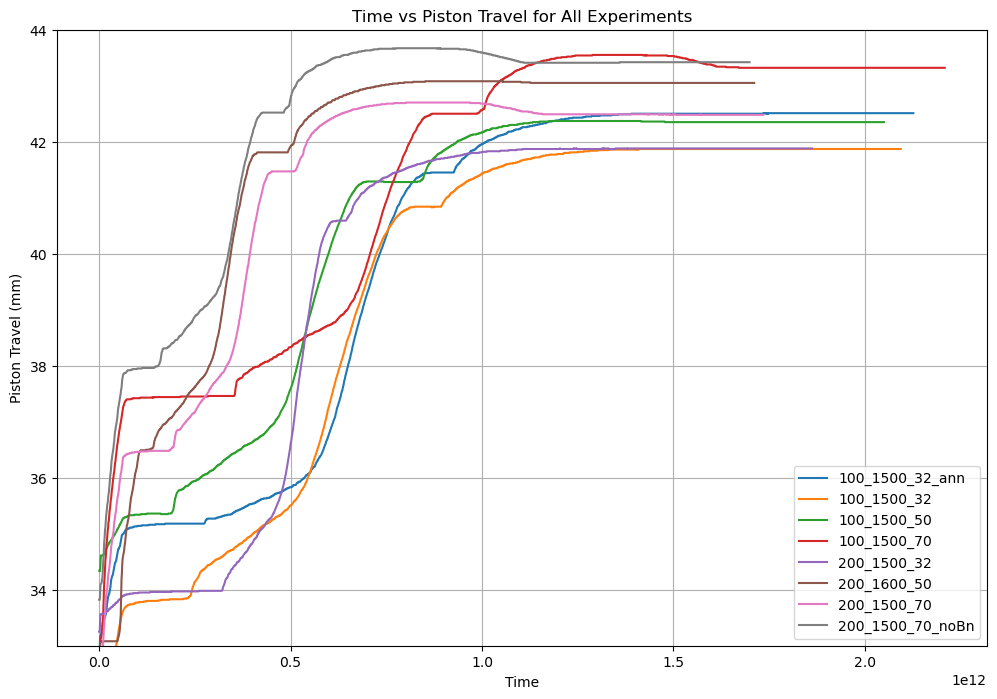

In [6]:
# write a code to plot time vs piston travel for all experiments in original_data
plt.figure(figsize=(12, 8))
for key, df in original_data.items():
    plt.plot(df['P.Zeit'], df['Abs Piston Tra.'], label=key)
plt.xlabel('Time')
plt.ylabel('Piston Travel (mm)')
plt.title('Time vs Piston Travel for All Experiments')
plt.ylim(33, 44)
plt.grid(True)
plt.legend()
plt.show()

In [47]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(20, 6))
for key in data.keys():
    ax1.plot(data[key]['Density'], data[key]['TravelDelta'], label=key)
# Add color bar to show the color scale
ax1.set_ylabel('Швидкість ущільнення')
#ax1.set_ylim(400, 1000)
ax1.set_xlim(30, 100)
#ax1.set_title('title')
ax1.set_xlabel('Відносна щільність')
ax1.grid(True)
plt.legend()
plt.show()


<Figure size 4000x600 with 0 Axes>

In [8]:
def plot_data_Seconds(data, title):
    setToPlot = data.copy()
    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    fig, ax2 = plt.subplots( figsize=(40, 6))
    fig, ax3 = plt.subplots( figsize=(40, 6))
    fig, ax4 = plt.subplots( figsize=(40, 6))
    fig, ax5 = plt.subplots( figsize=(40, 6))
    fig, ax6 = plt.subplots( figsize=(40, 6))
    sc2 = ax1.plot(setToPlot['seconds'], setToPlot['Force'], color='black')
    sc2 = ax2.plot(setToPlot['seconds'], setToPlot['TravelRelativeTempCorrected'], color='green')
    sc2 = ax2.plot(setToPlot['seconds'], setToPlot['TravelRelative'], color='blue')
    sc2 = ax3.plot(setToPlot['seconds'], setToPlot['Pyrometer'], color='orange')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['Power'], color='red')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['U RMS'], color='orange')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['I RMS'], color='purple')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['U RMS']/setToPlot['I RMS'], color='black')
    sc2 = ax5.plot(setToPlot['seconds'], setToPlot['Density'], color='black')
    sc2 = ax6.plot(setToPlot['seconds'], setToPlot['TravelDelta'], color='black')

    ax4.set_ylim(0,10)
    ax1.set_ylabel('Force')
    ax2.set_ylabel('TravelRelativeTempCorrected')
    ax3.set_ylabel('Pyrometer')
    ax4.set_ylabel('Power')
    ax5.set_ylabel('Density')
    ax6.set_ylabel('TravelDelta')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    ax5.grid(True)
    ax6.grid(True)
    ax1.set_title(title)
    ax2.set_title(title)
    ax3.set_title(title)
    ax4.set_title(title)
    ax5.set_title(title)
    ax6.set_title(title)
    plt.show()

<Figure size 4000x600 with 0 Axes>

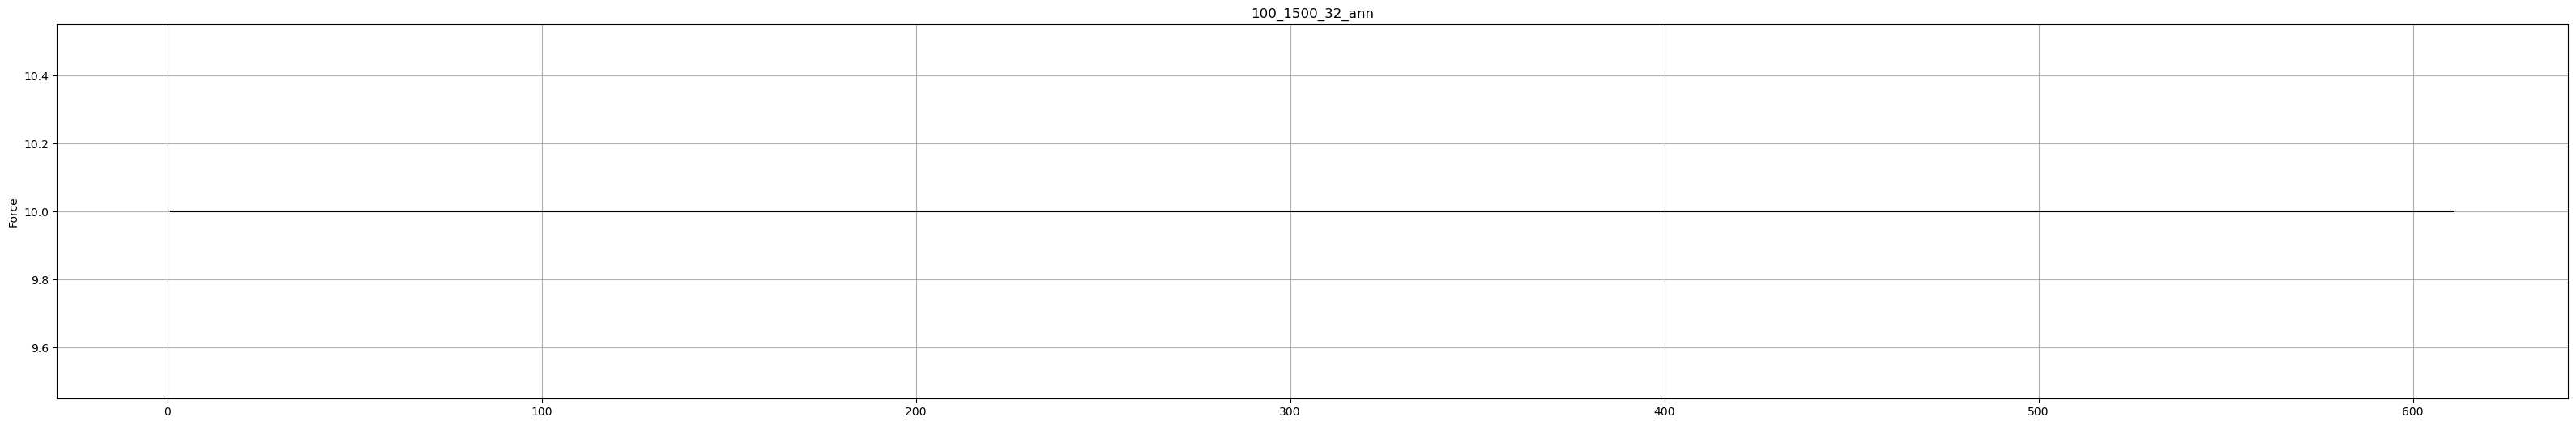

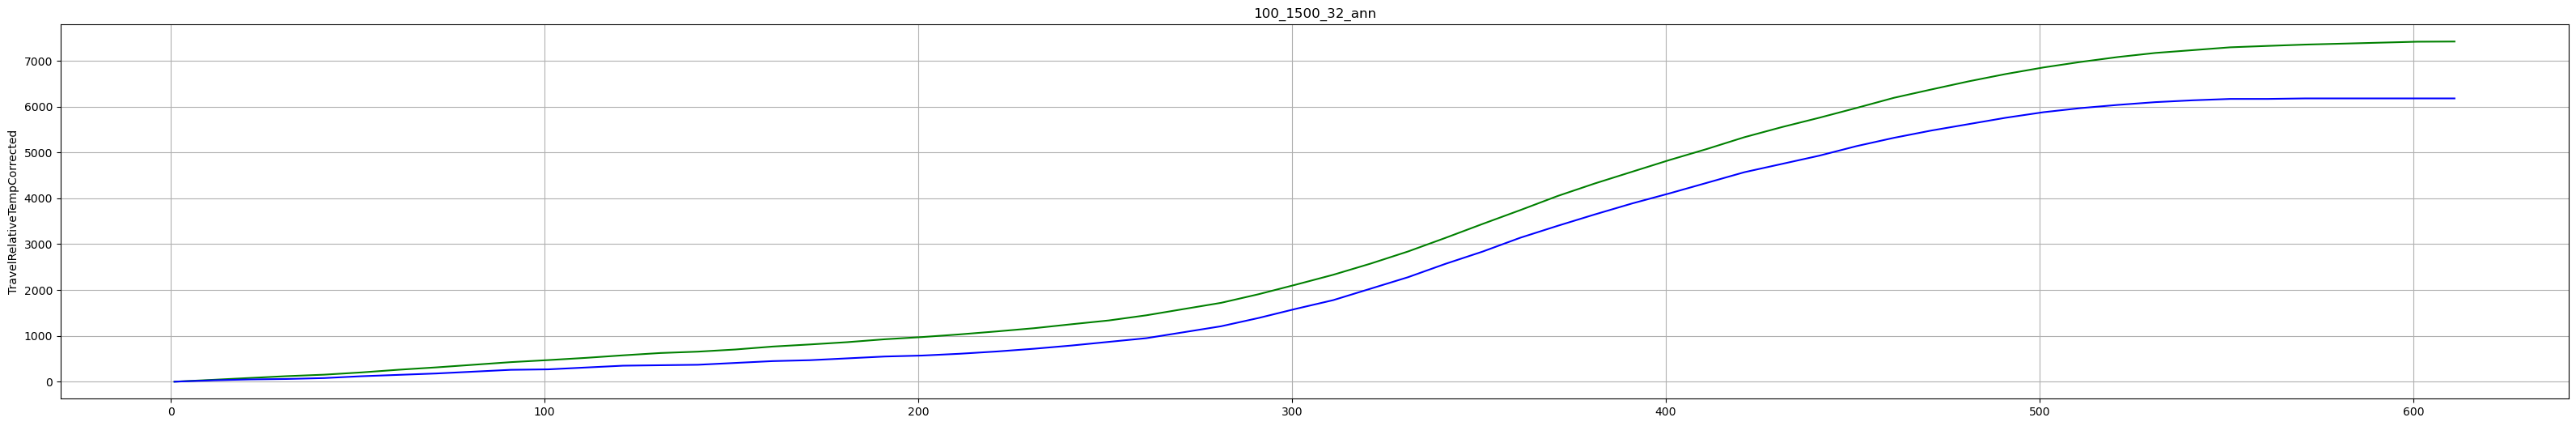

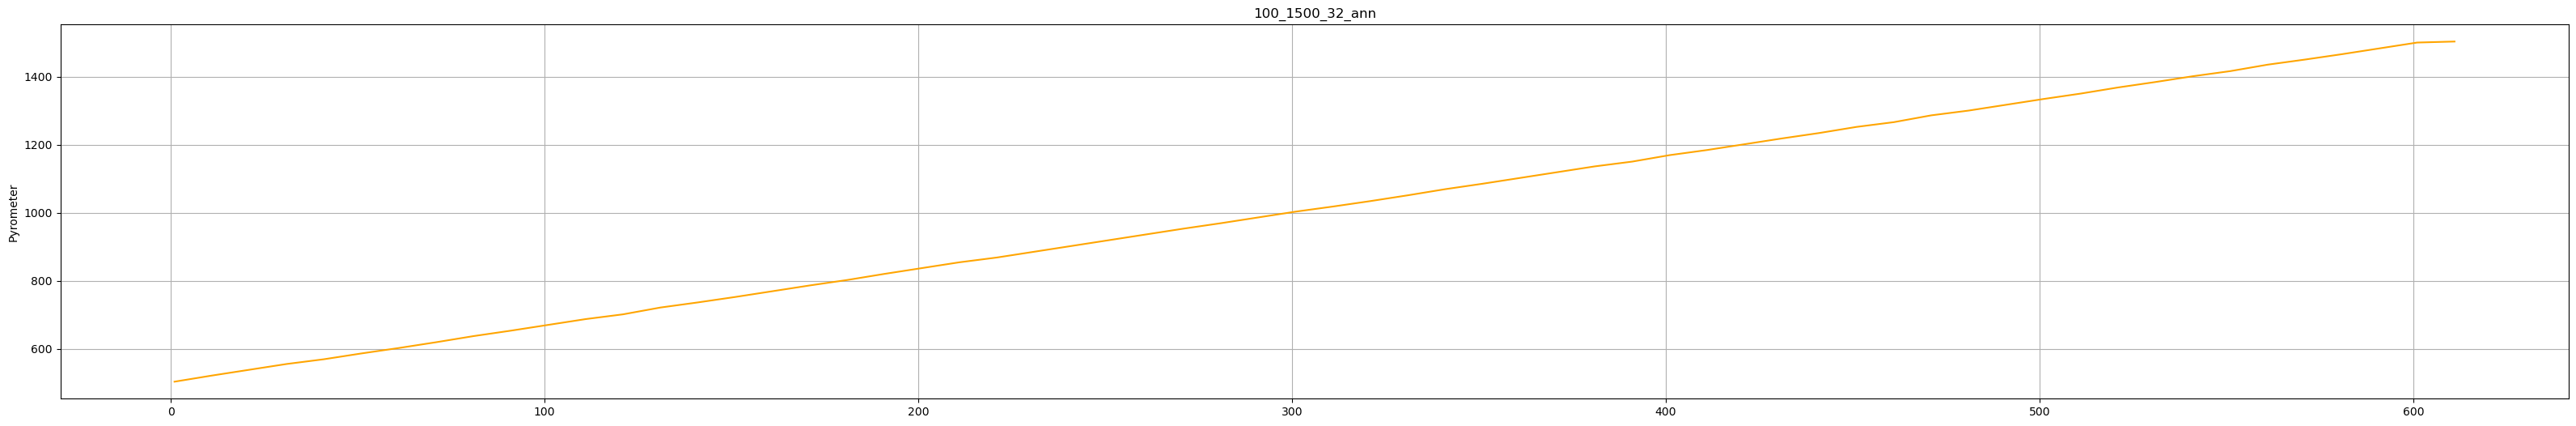

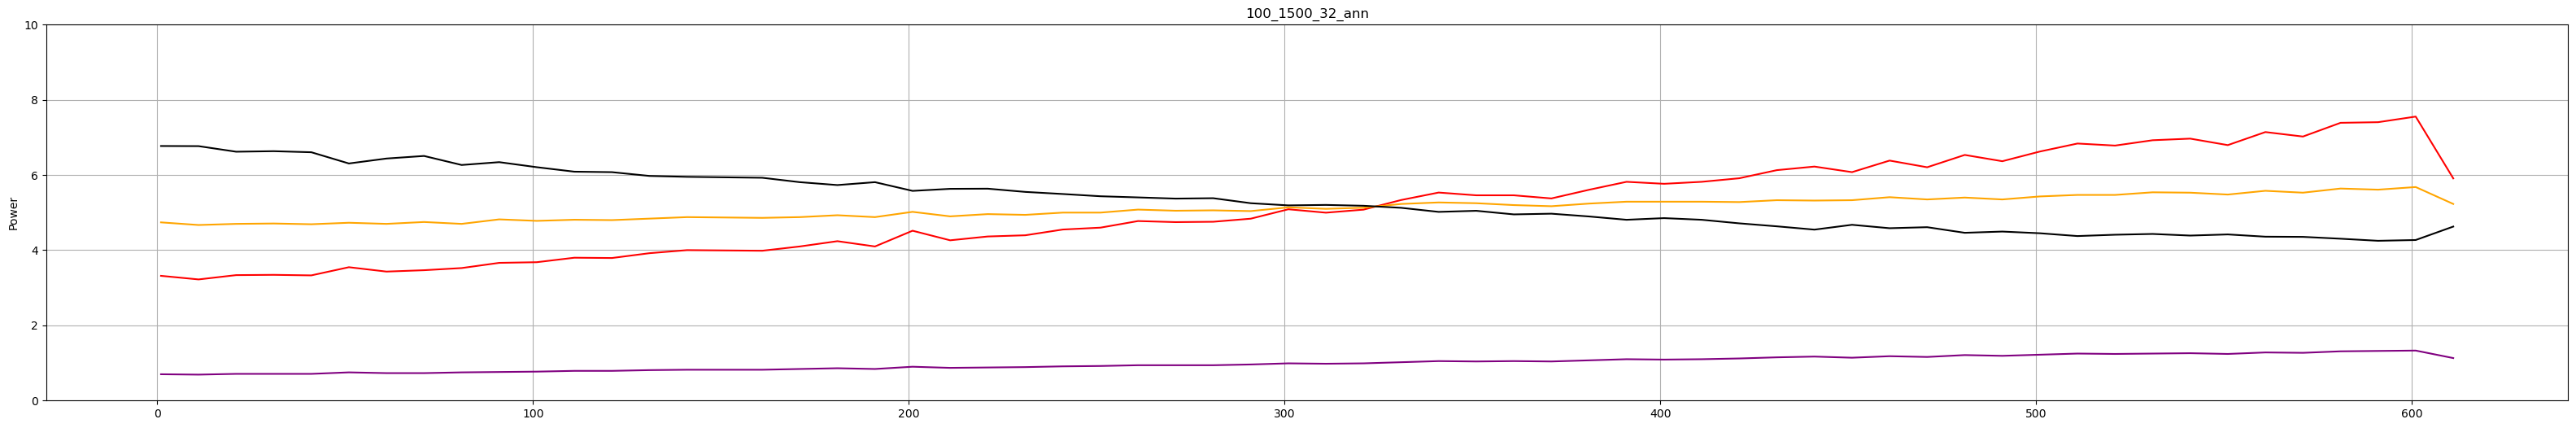

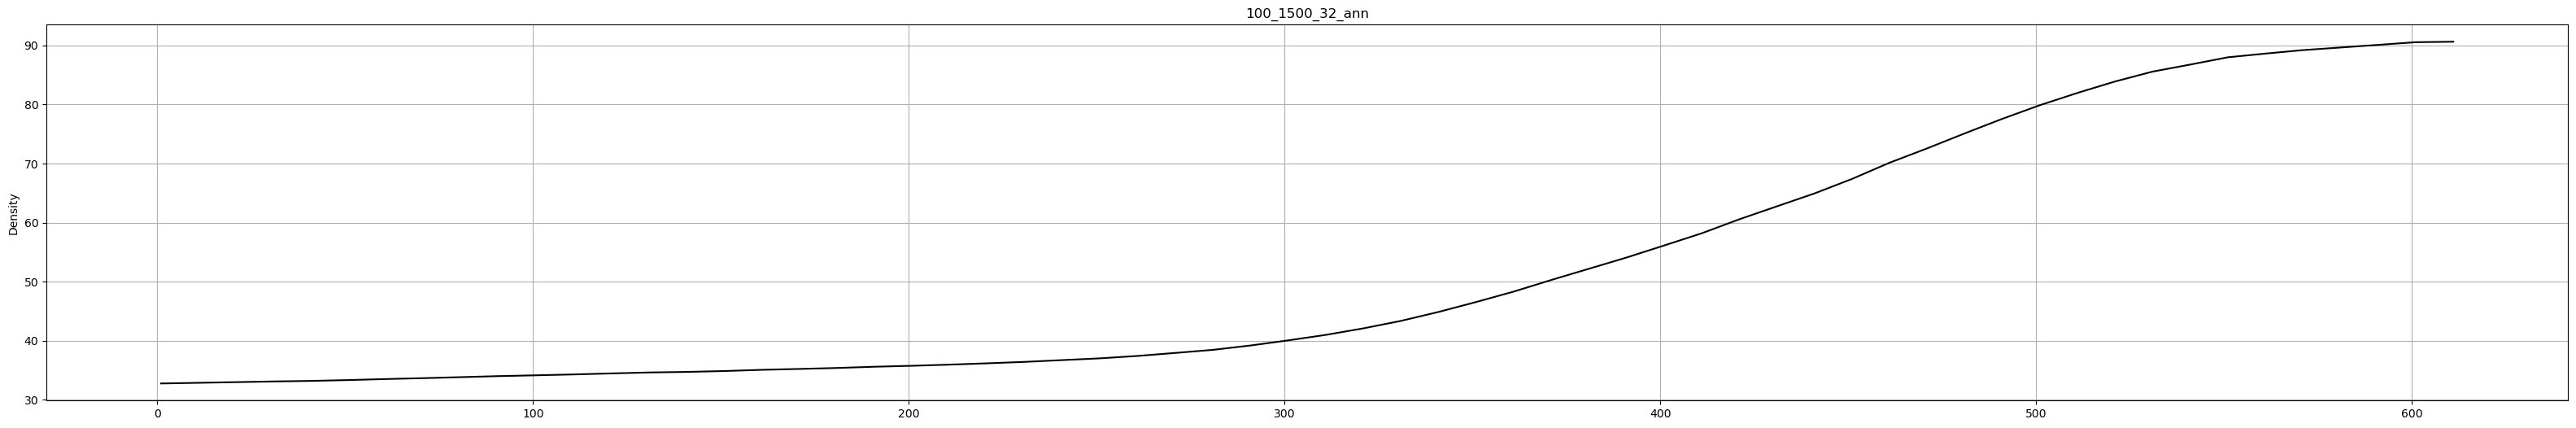

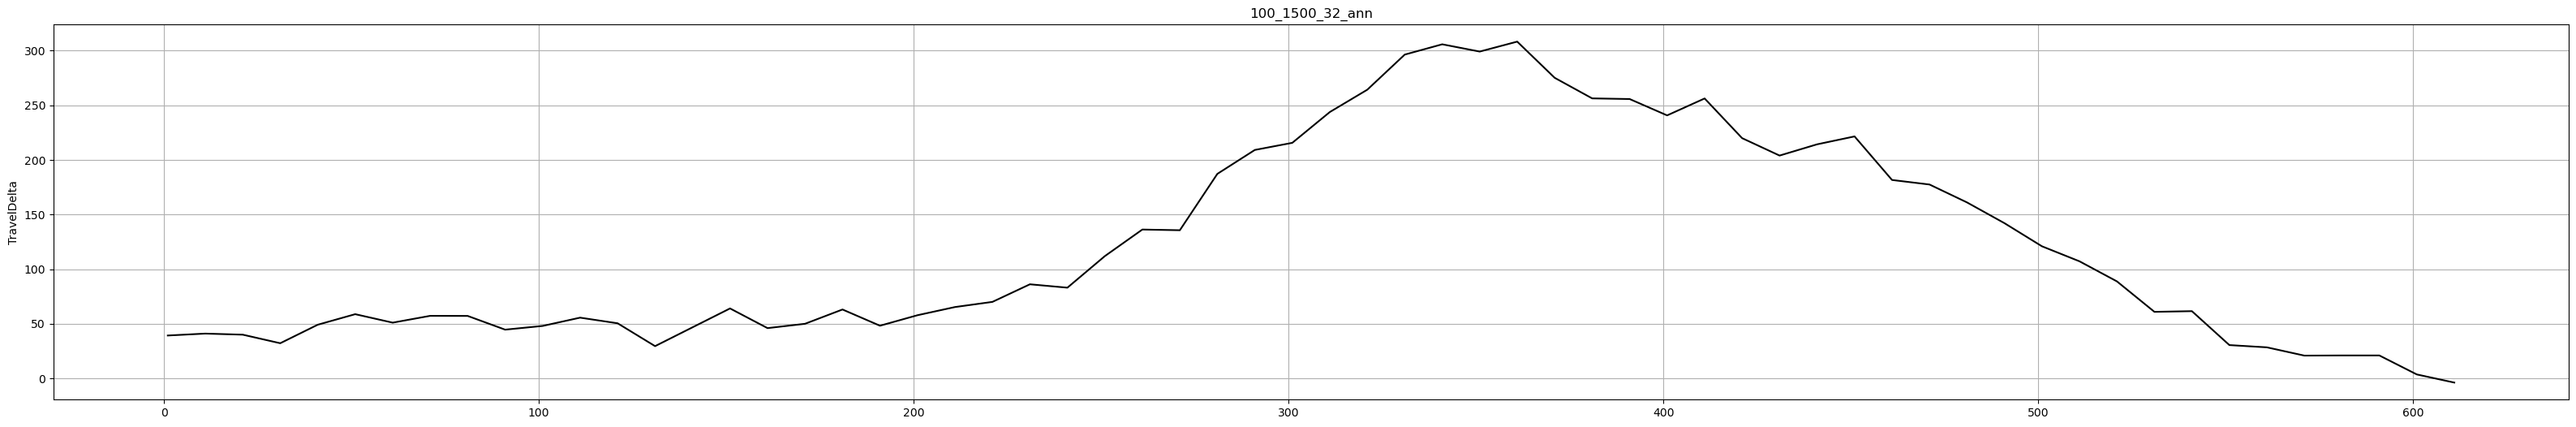

<Figure size 4000x600 with 0 Axes>

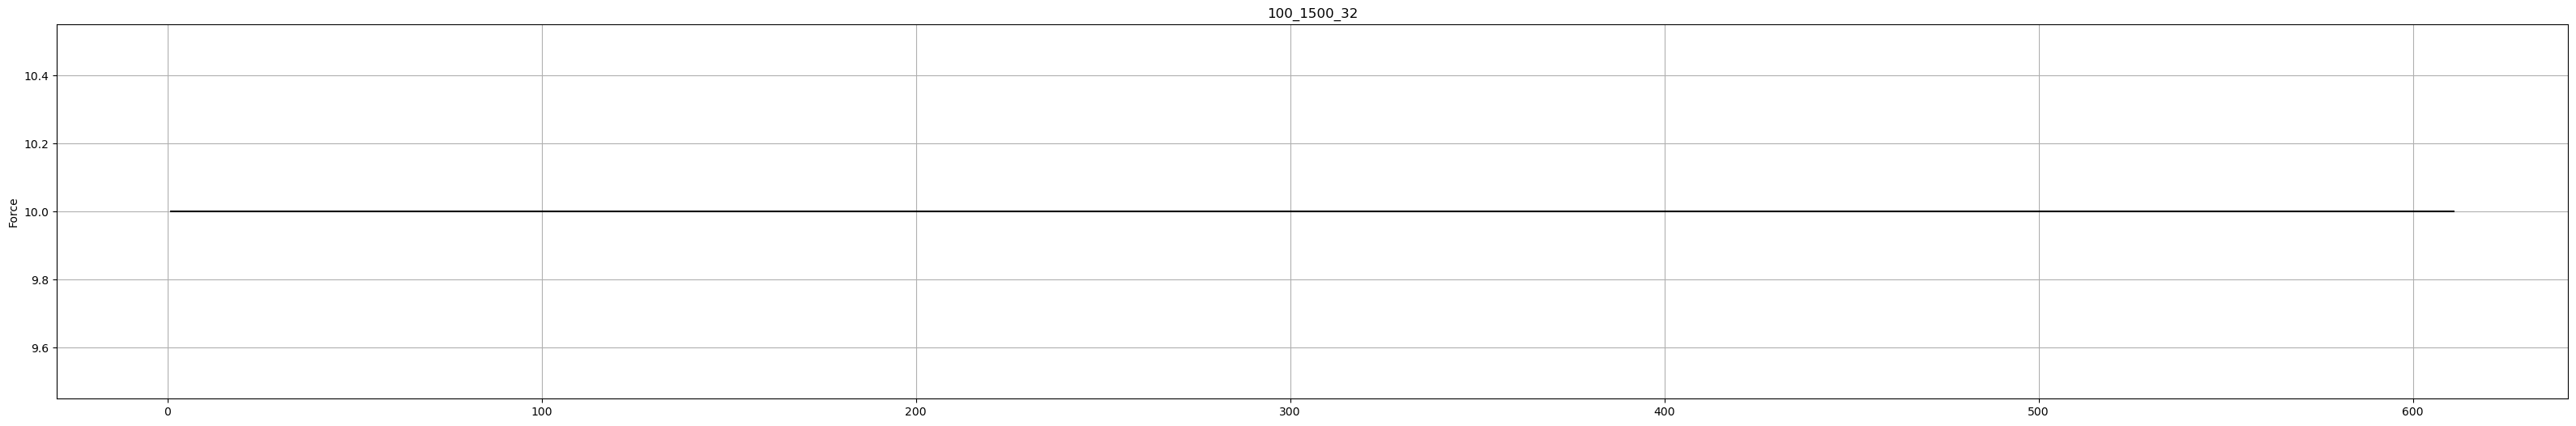

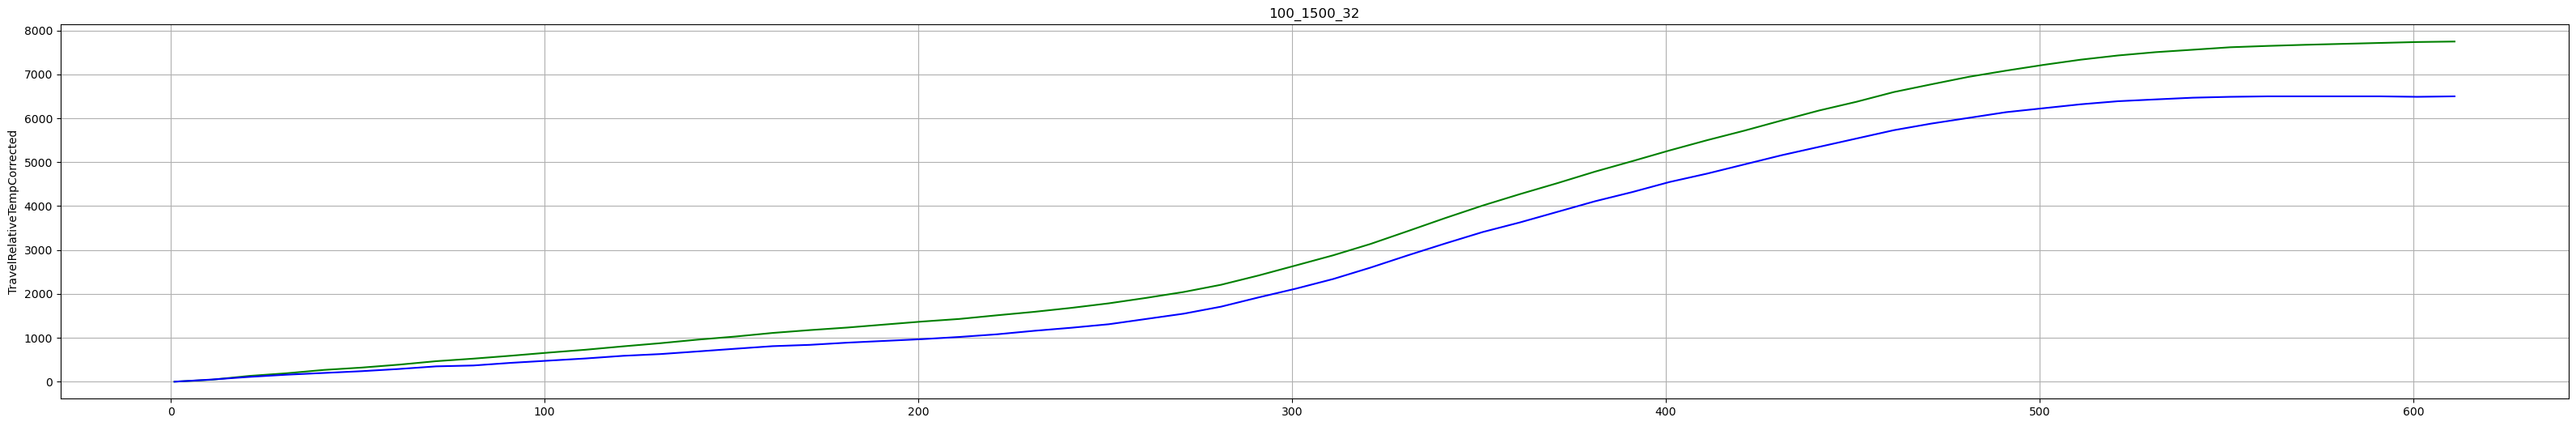

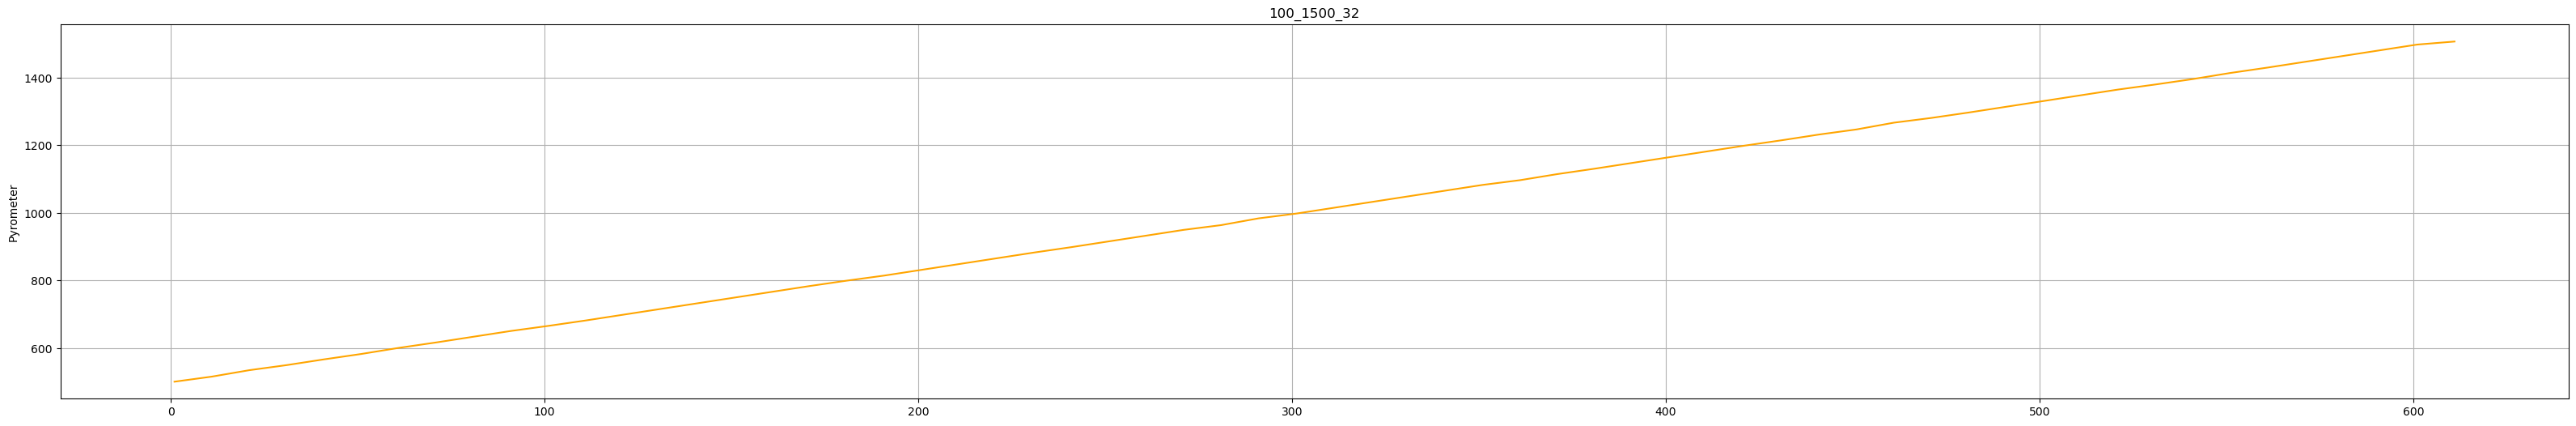

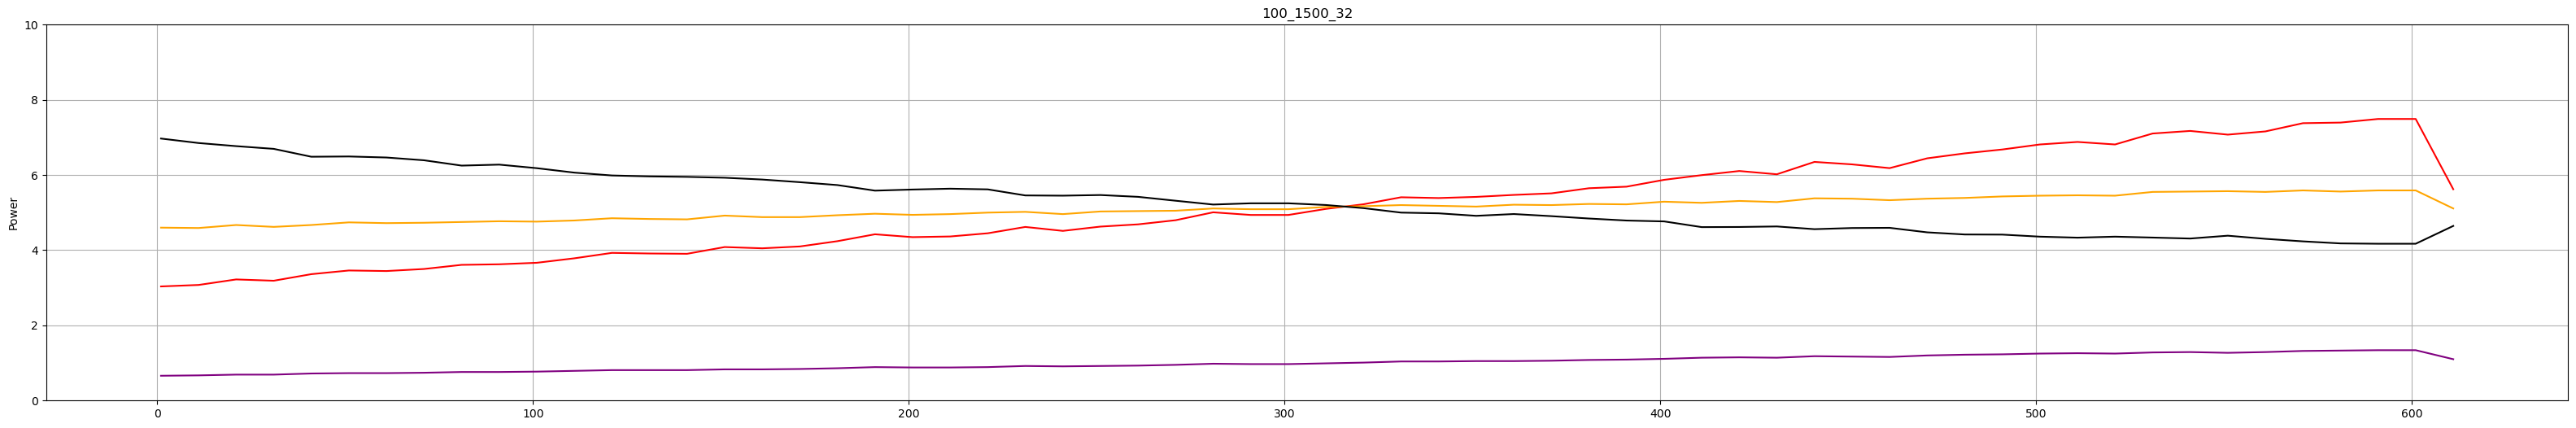

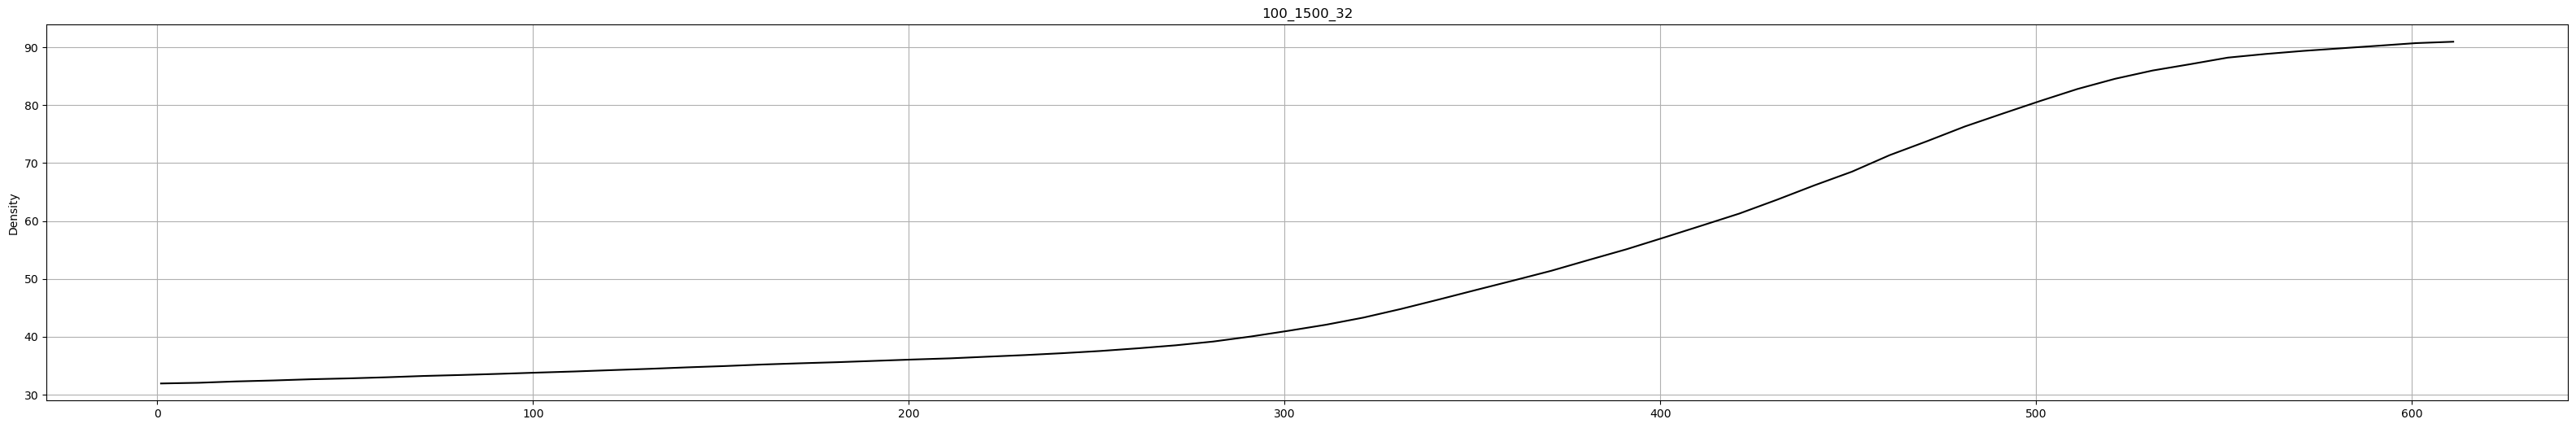

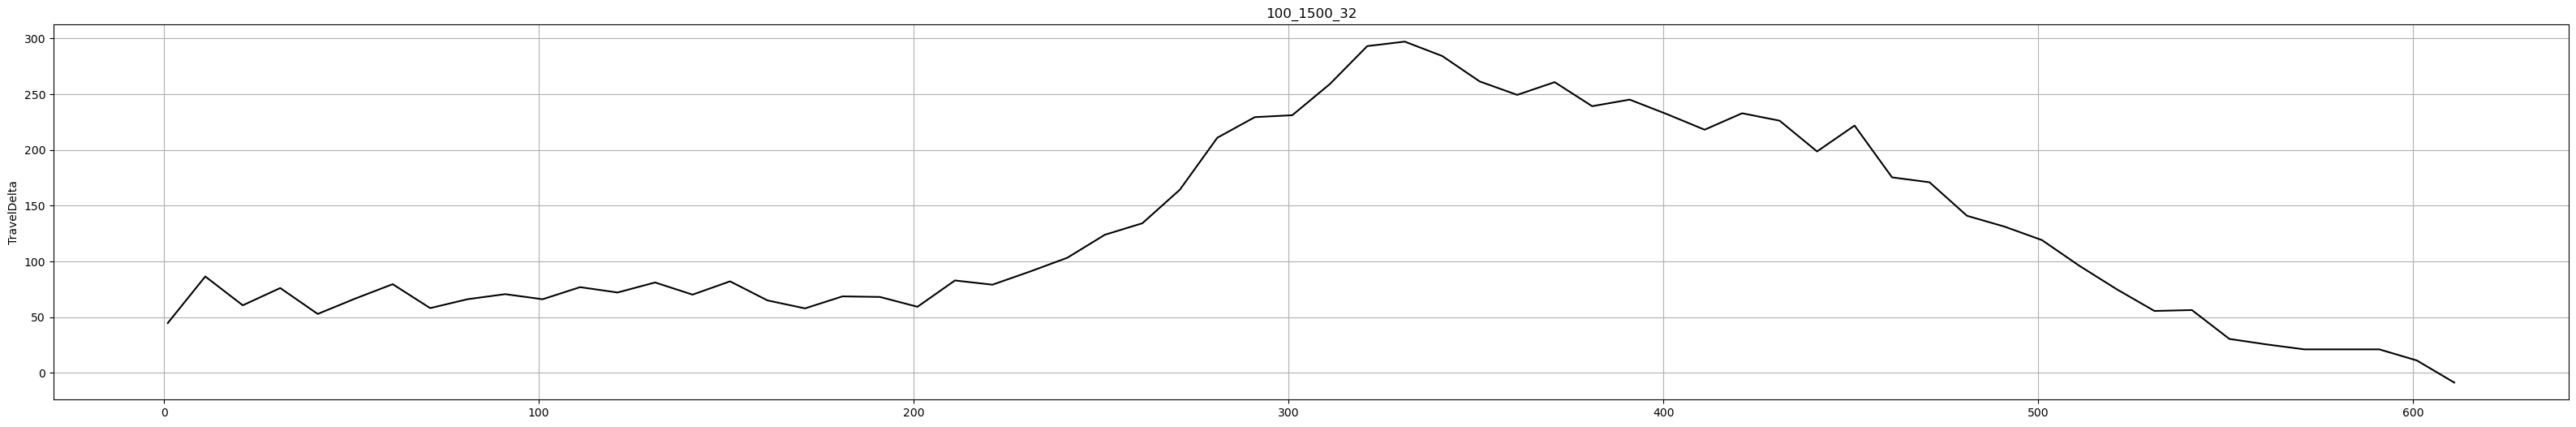

<Figure size 4000x600 with 0 Axes>

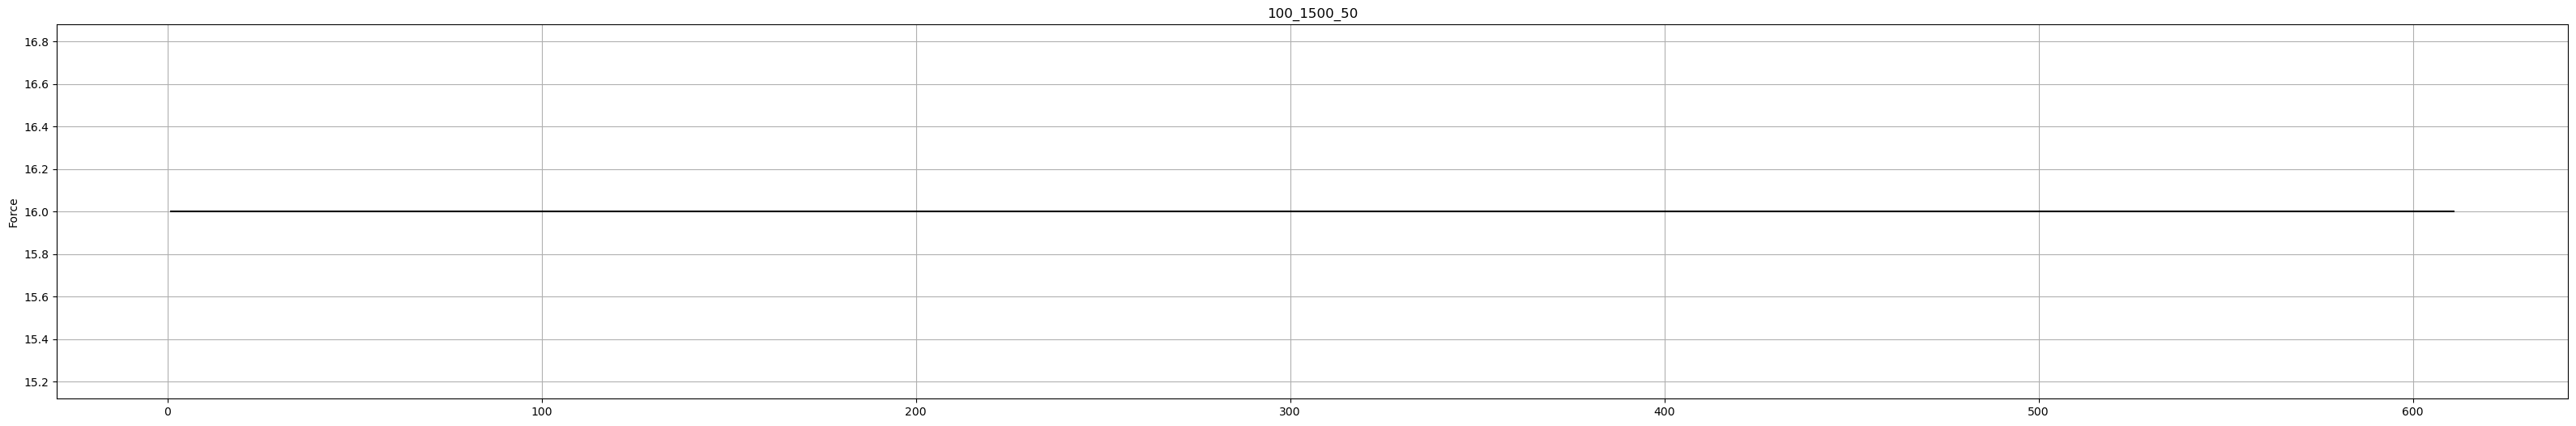

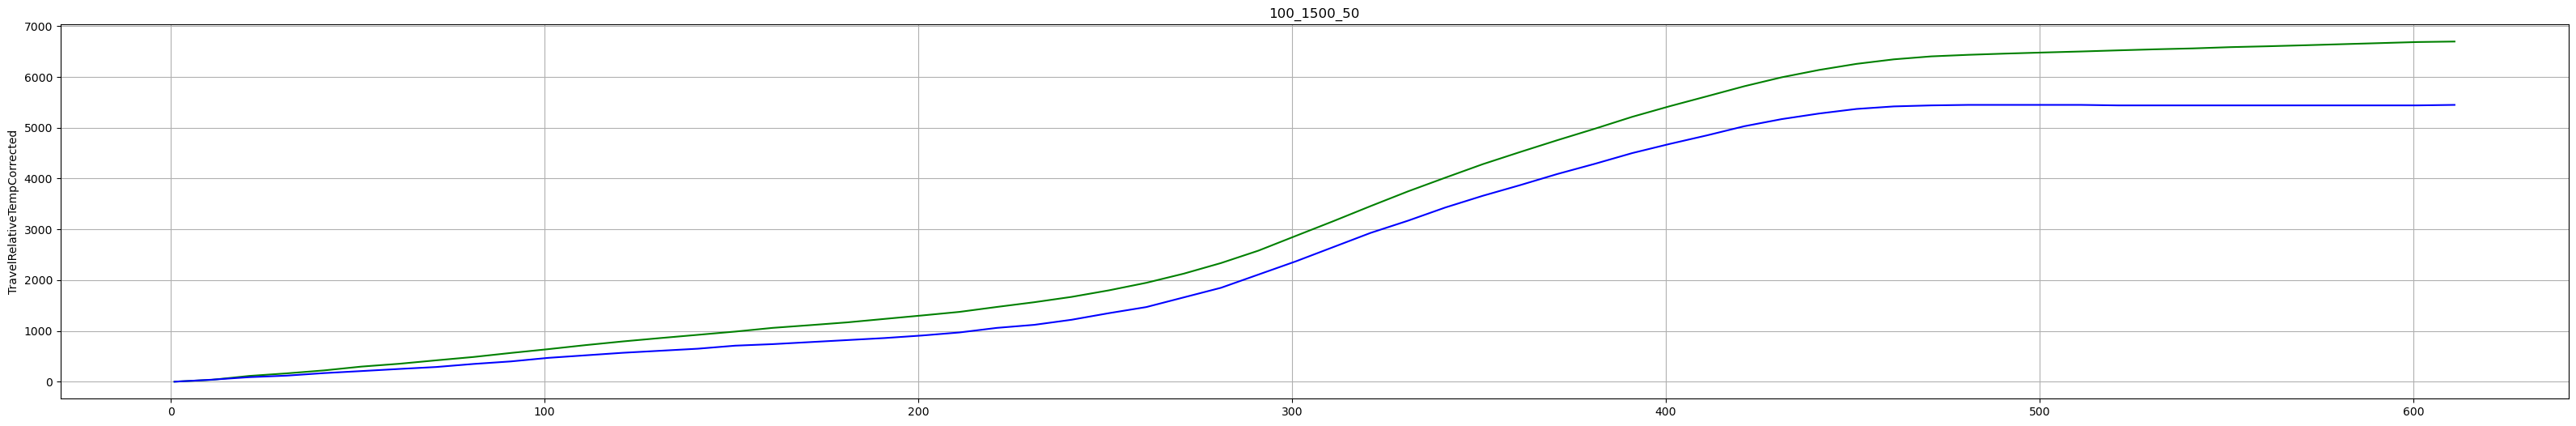

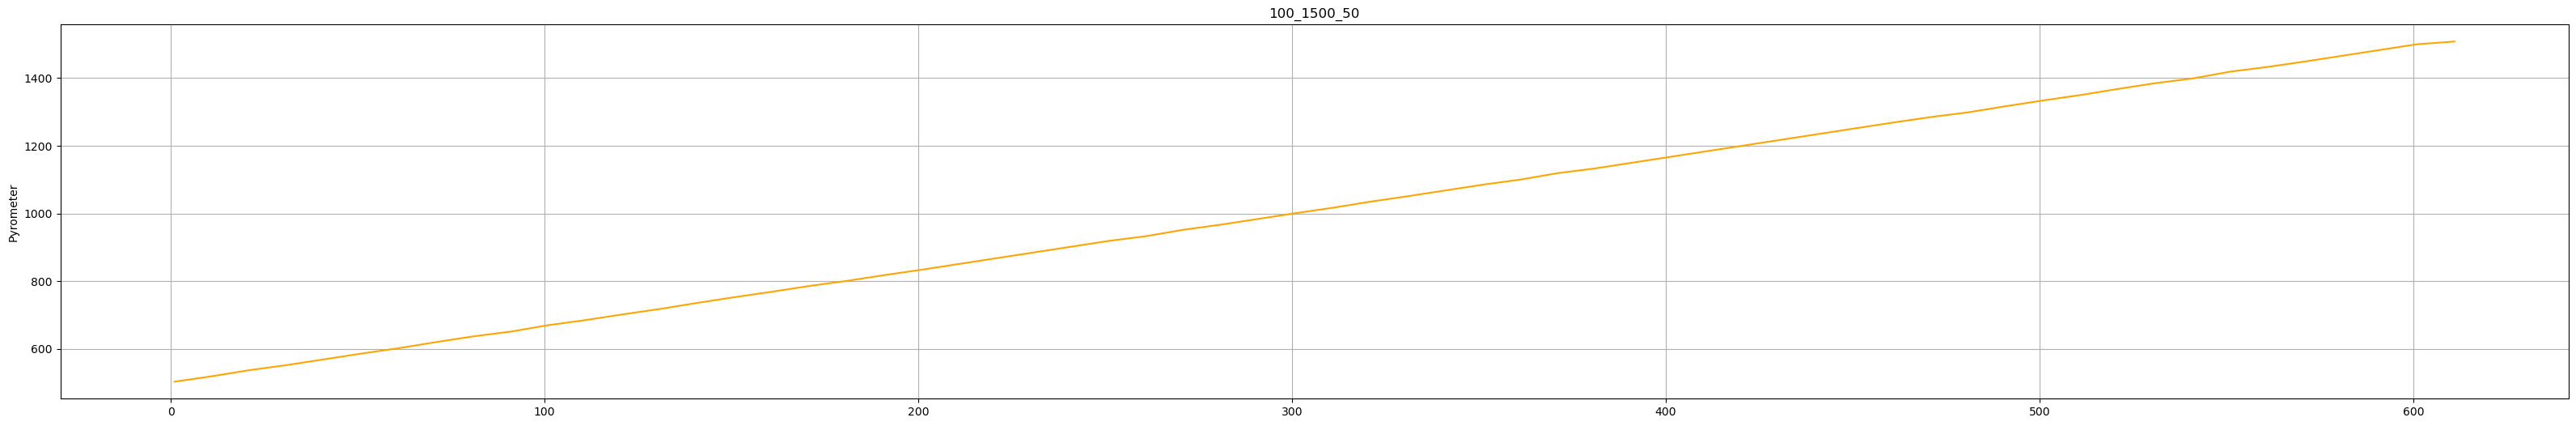

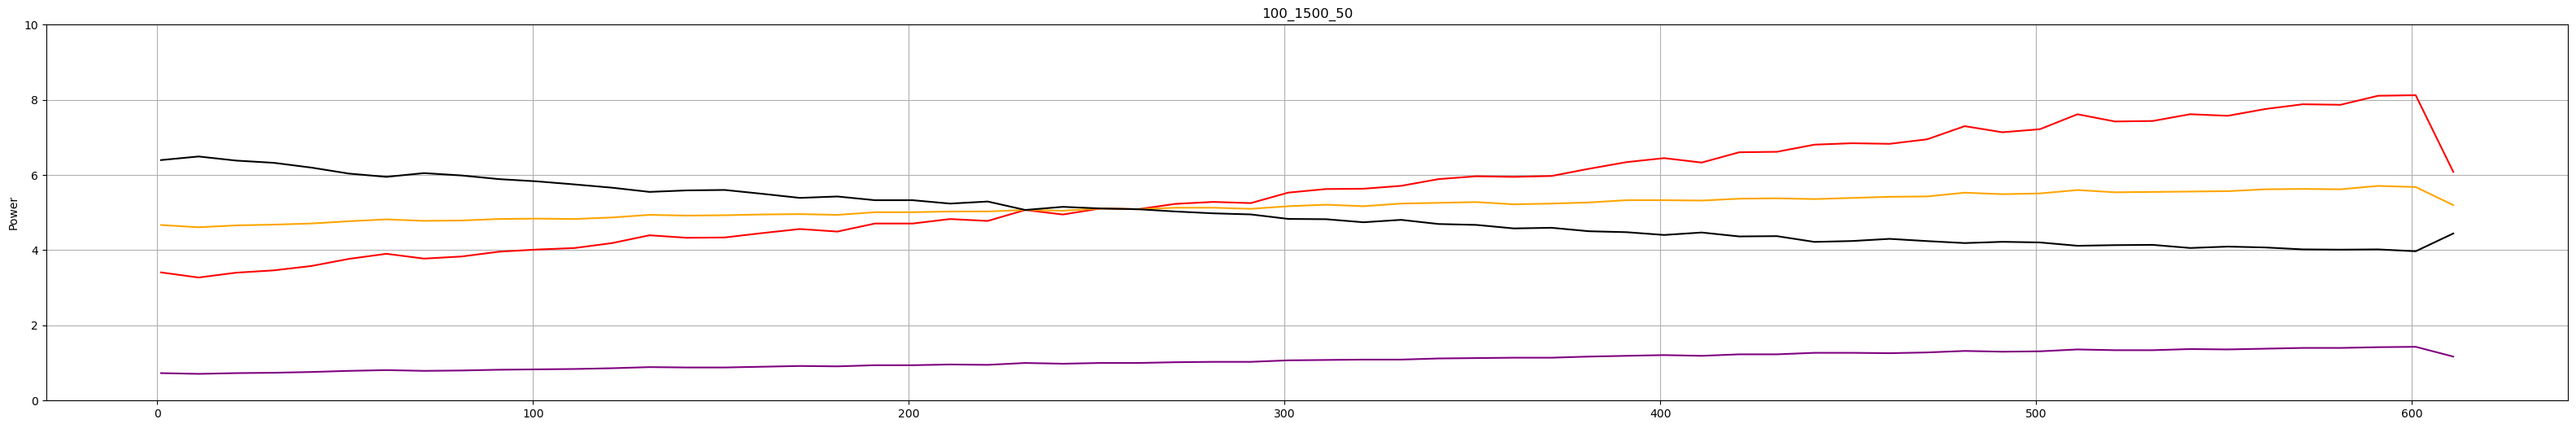

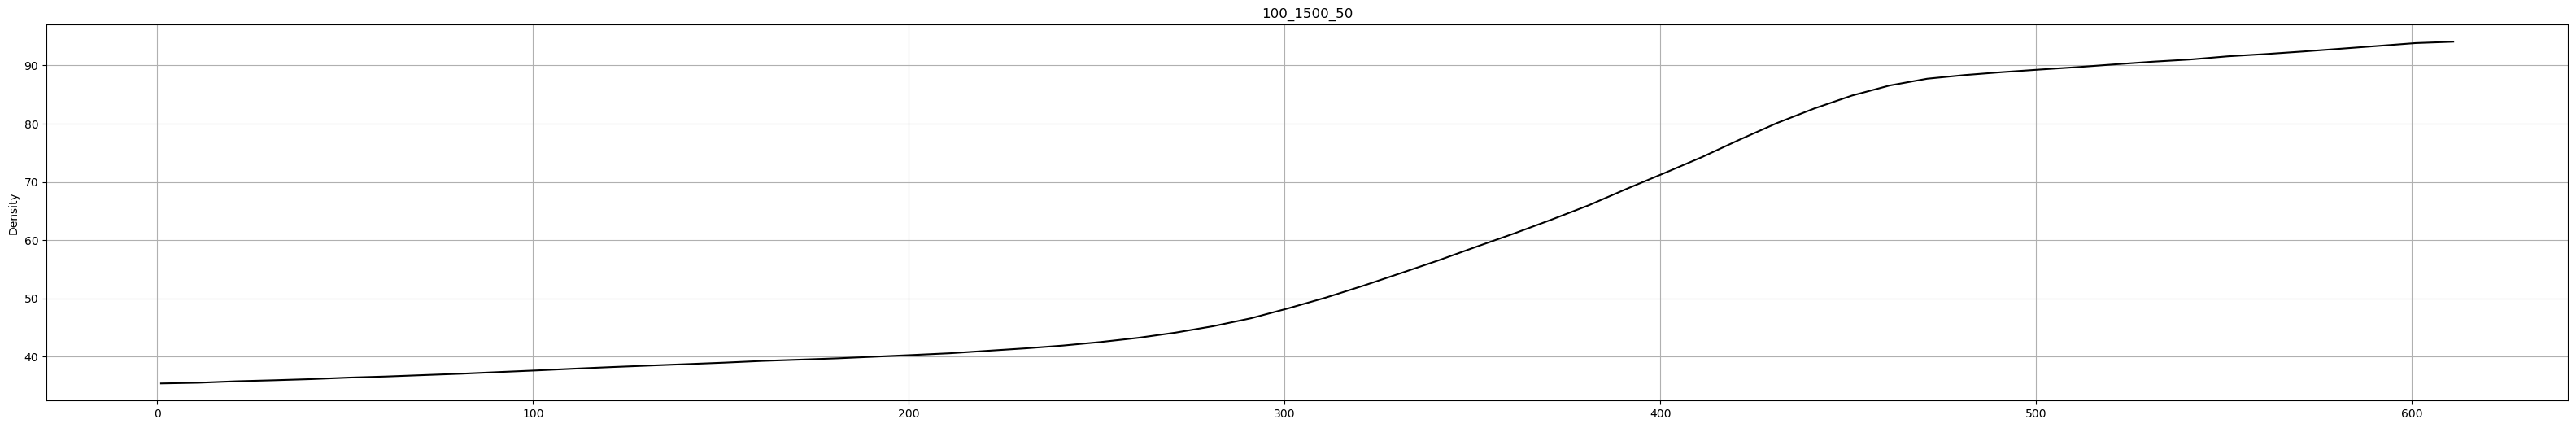

<Figure size 4000x600 with 0 Axes>

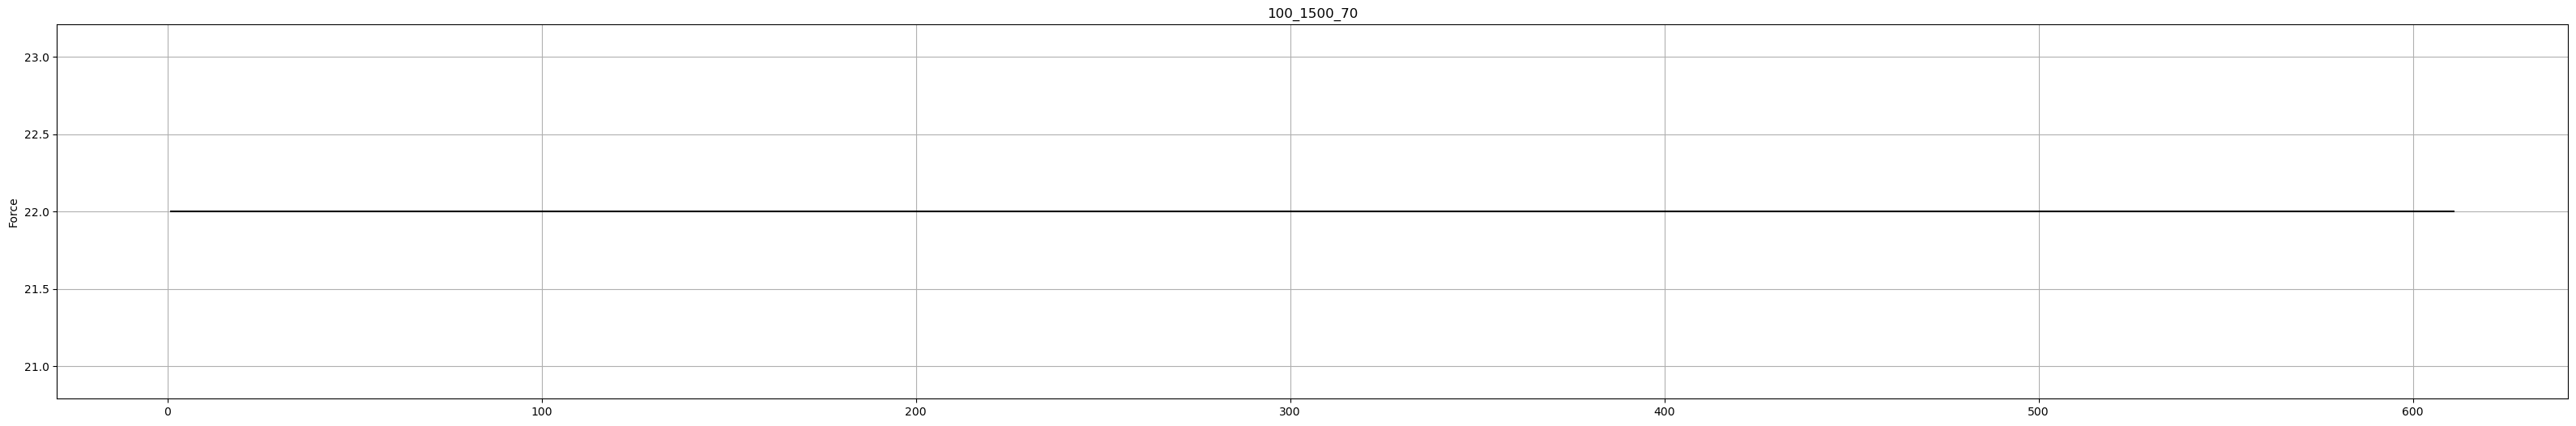

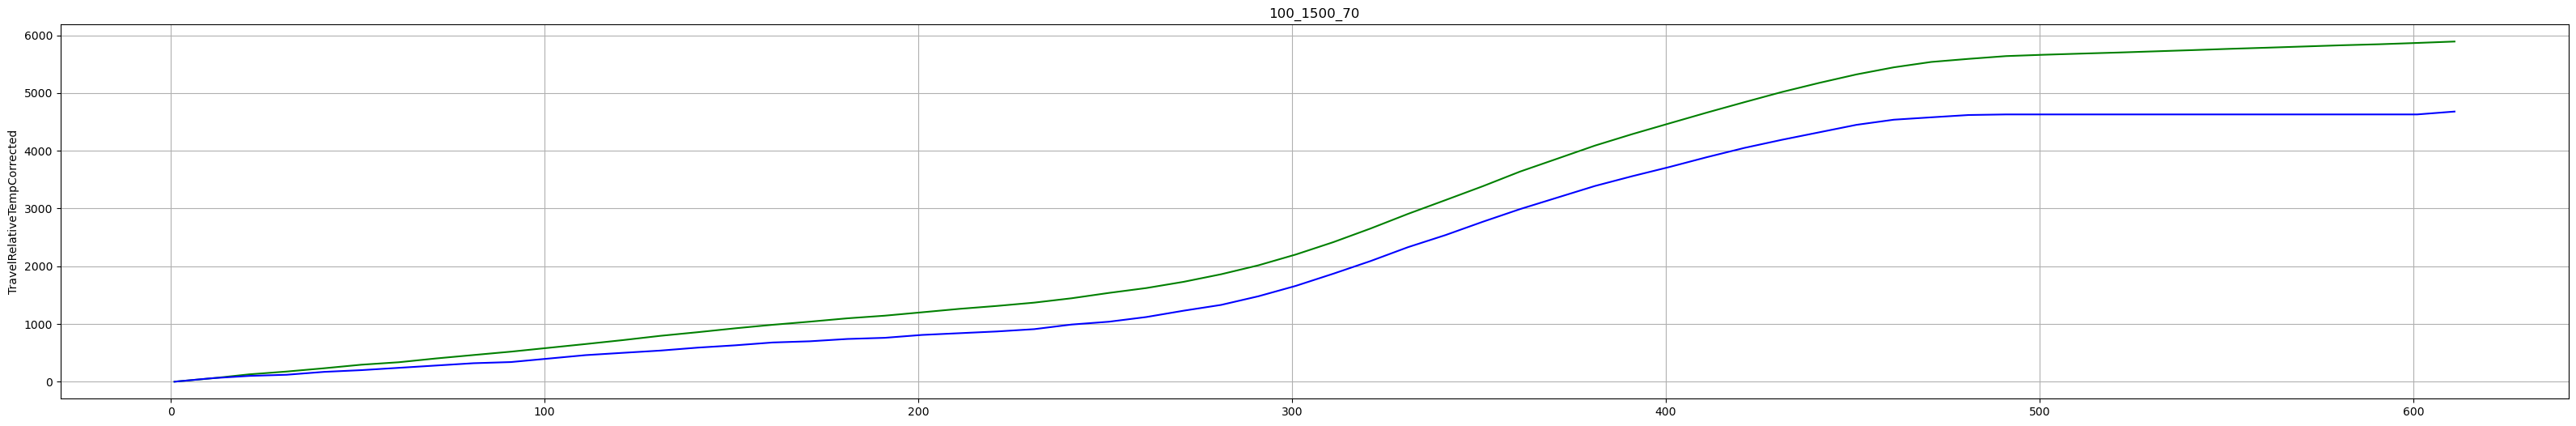

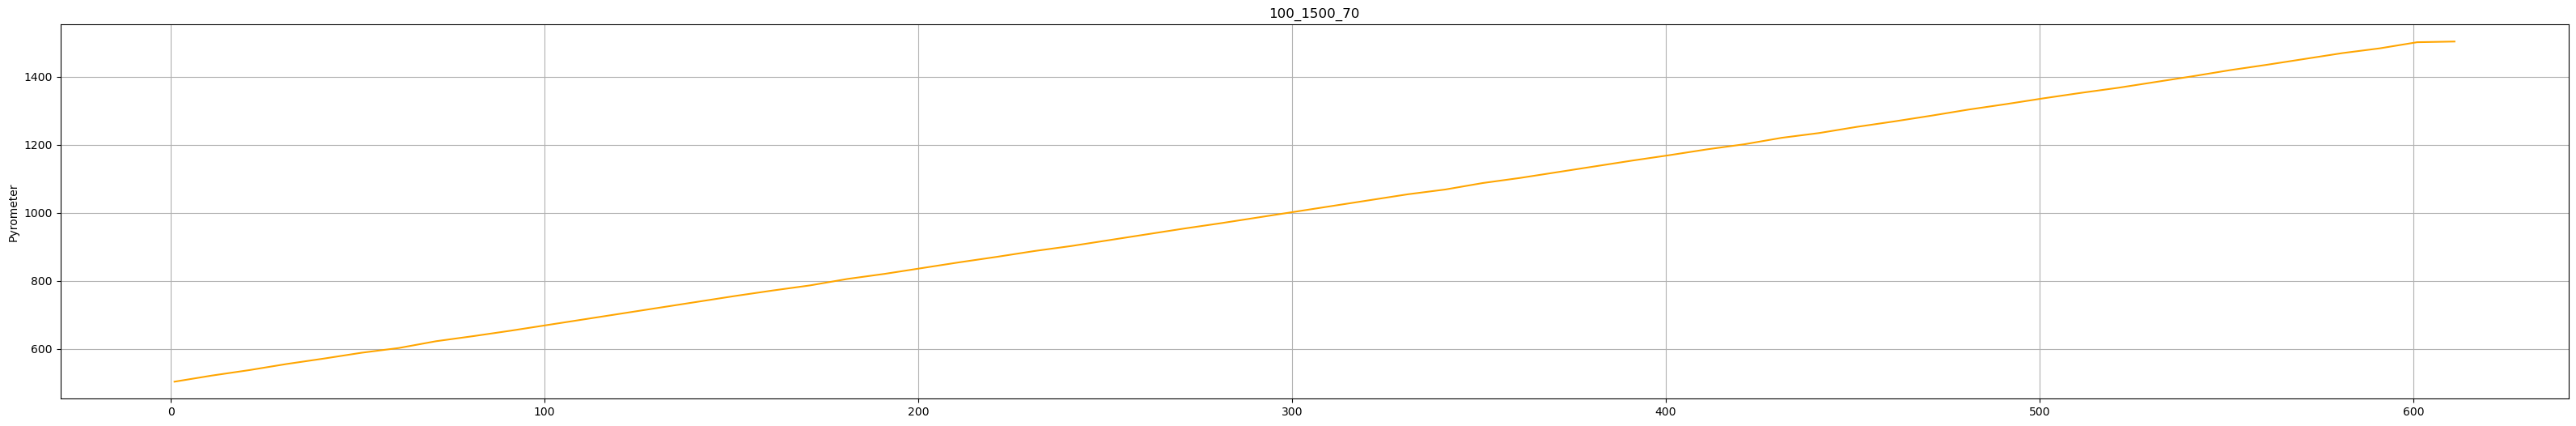

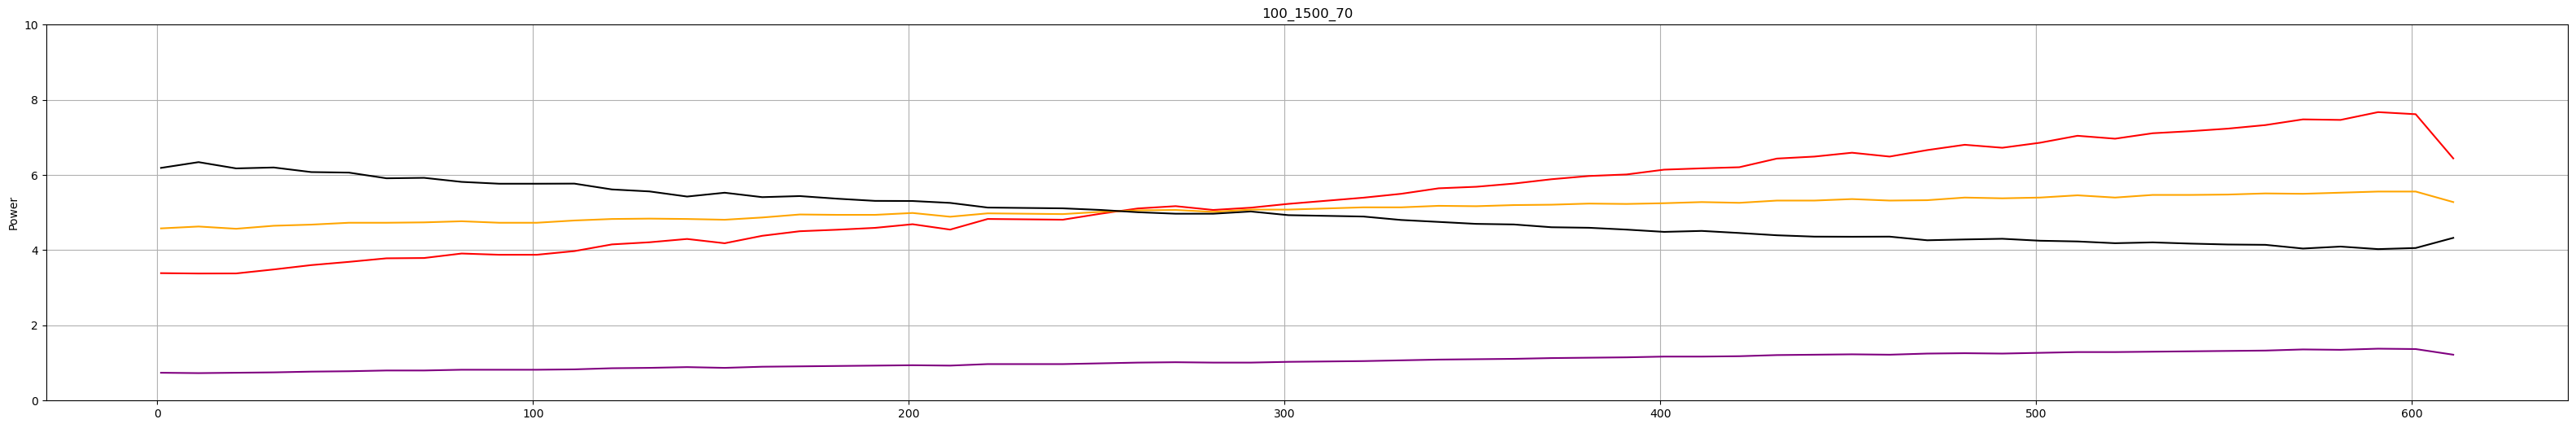

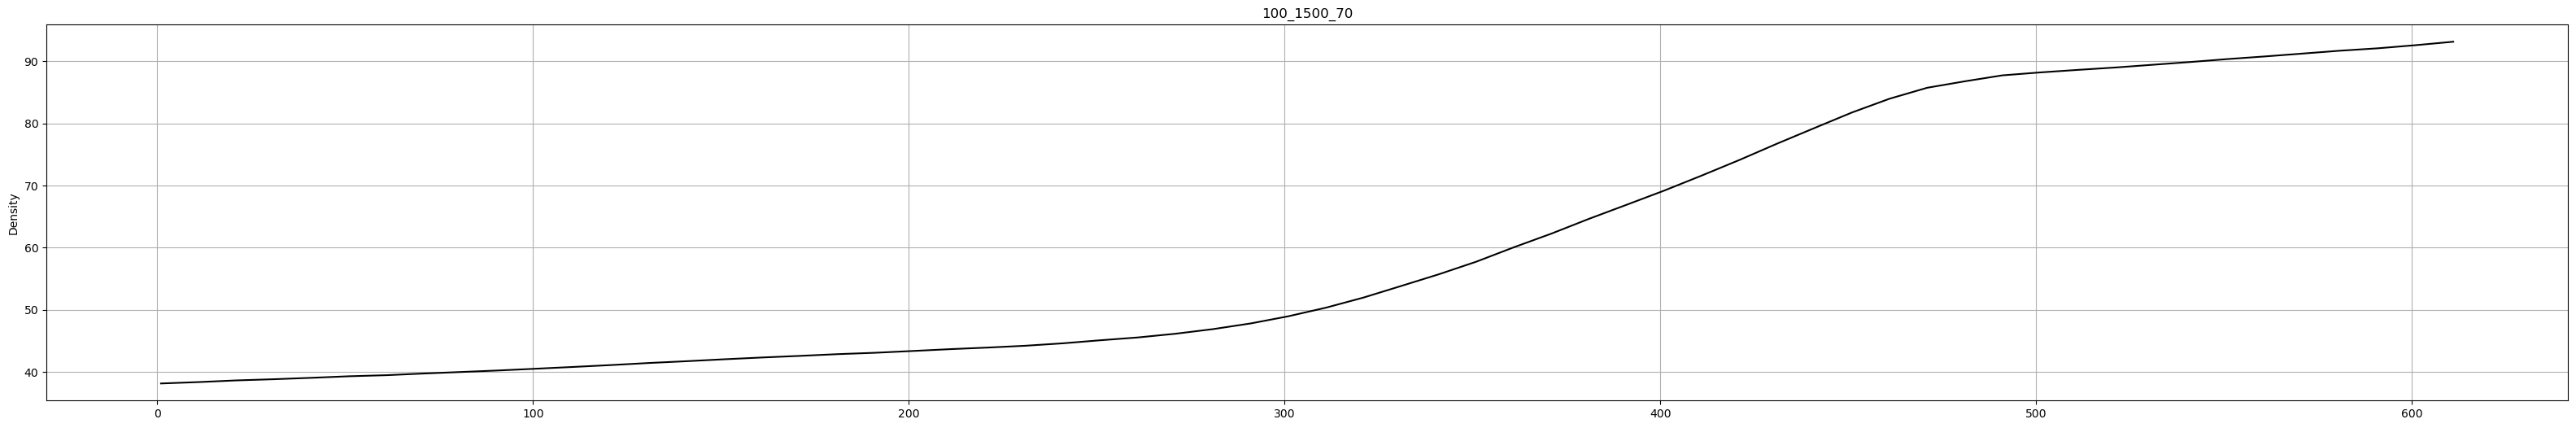

<Figure size 4000x600 with 0 Axes>

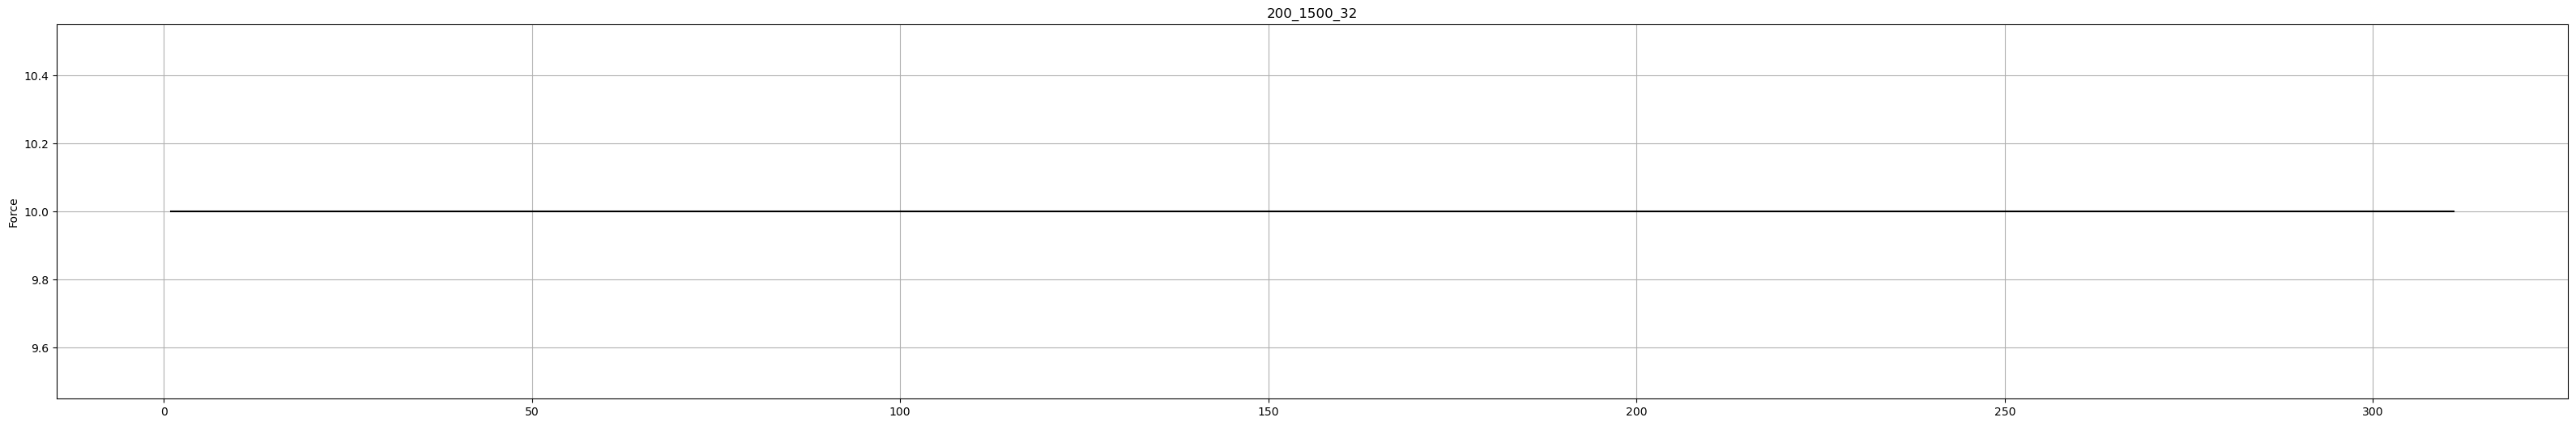

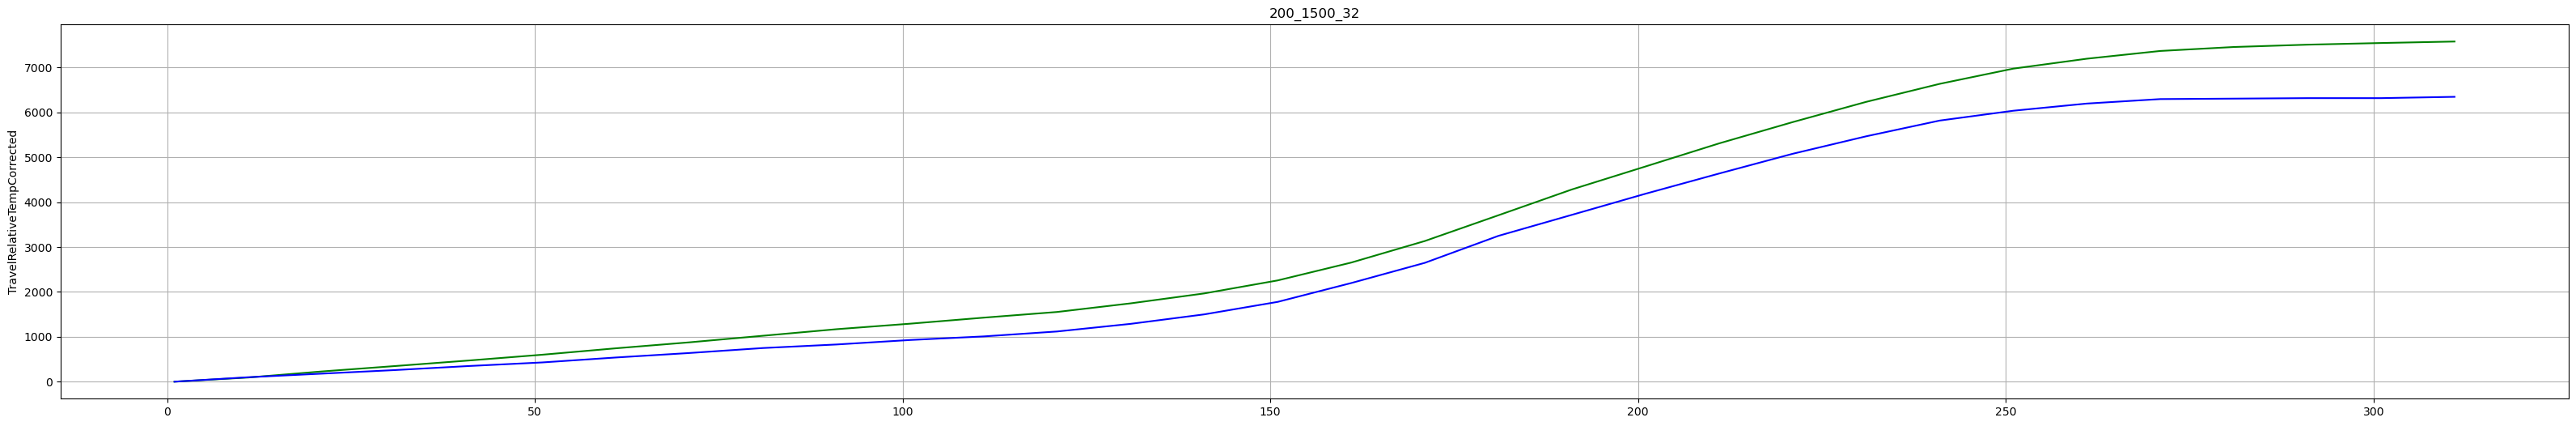

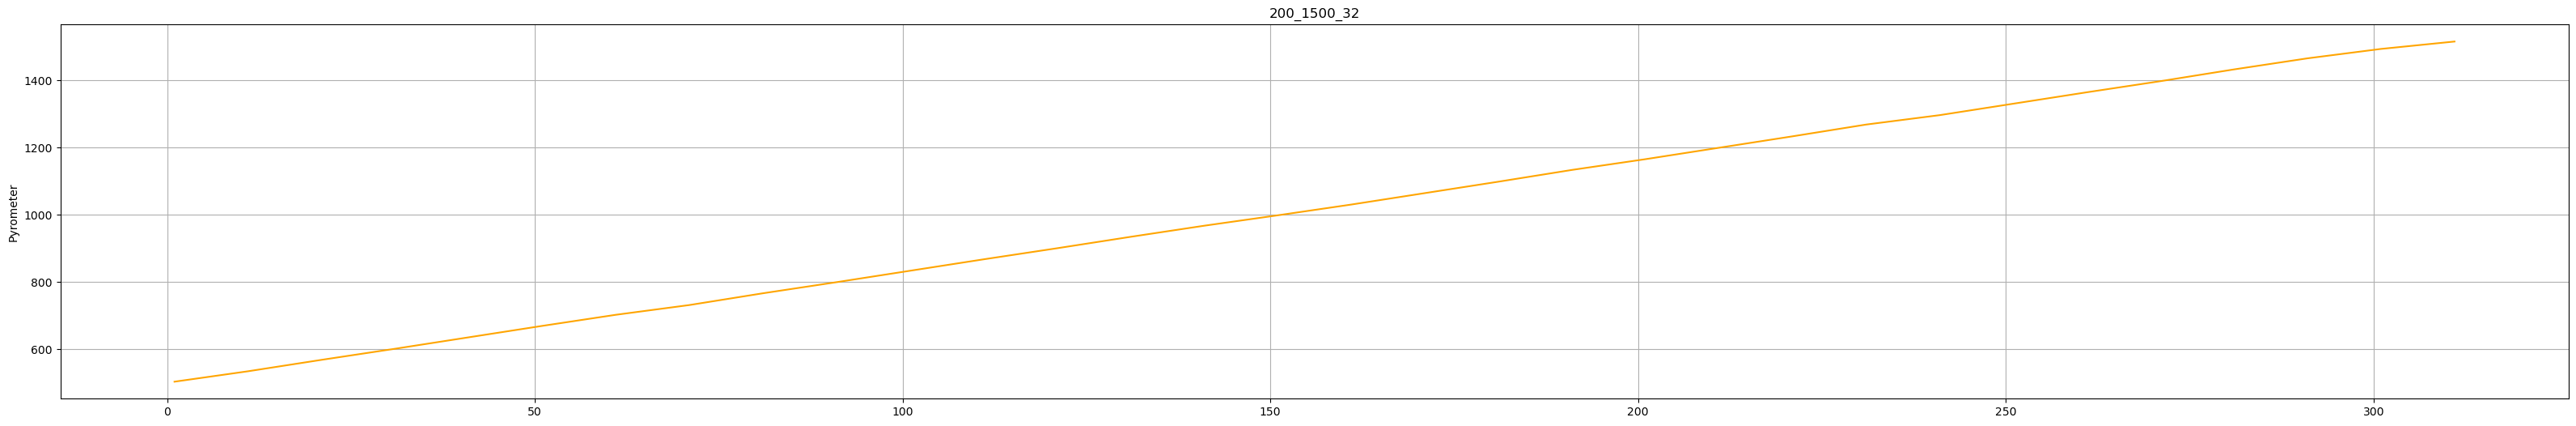

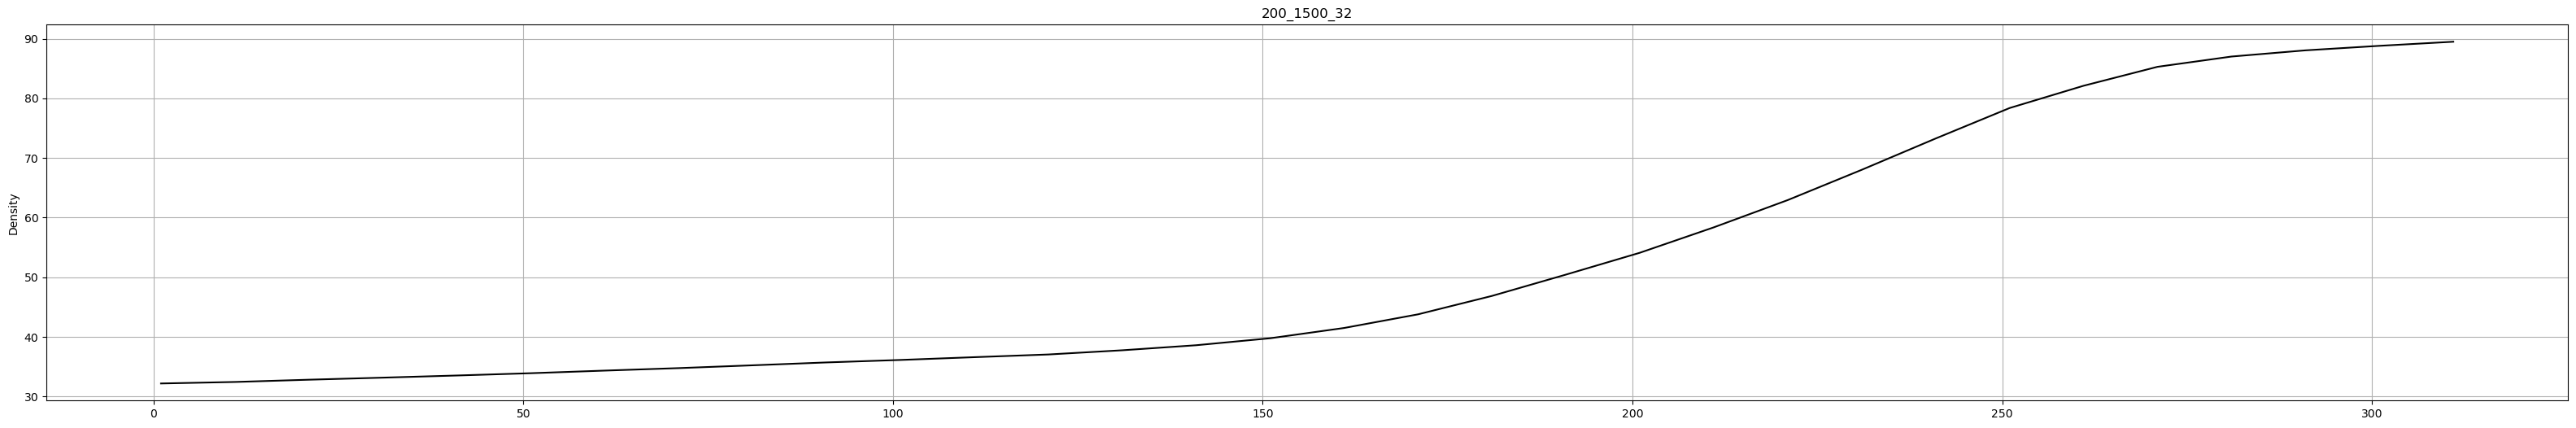

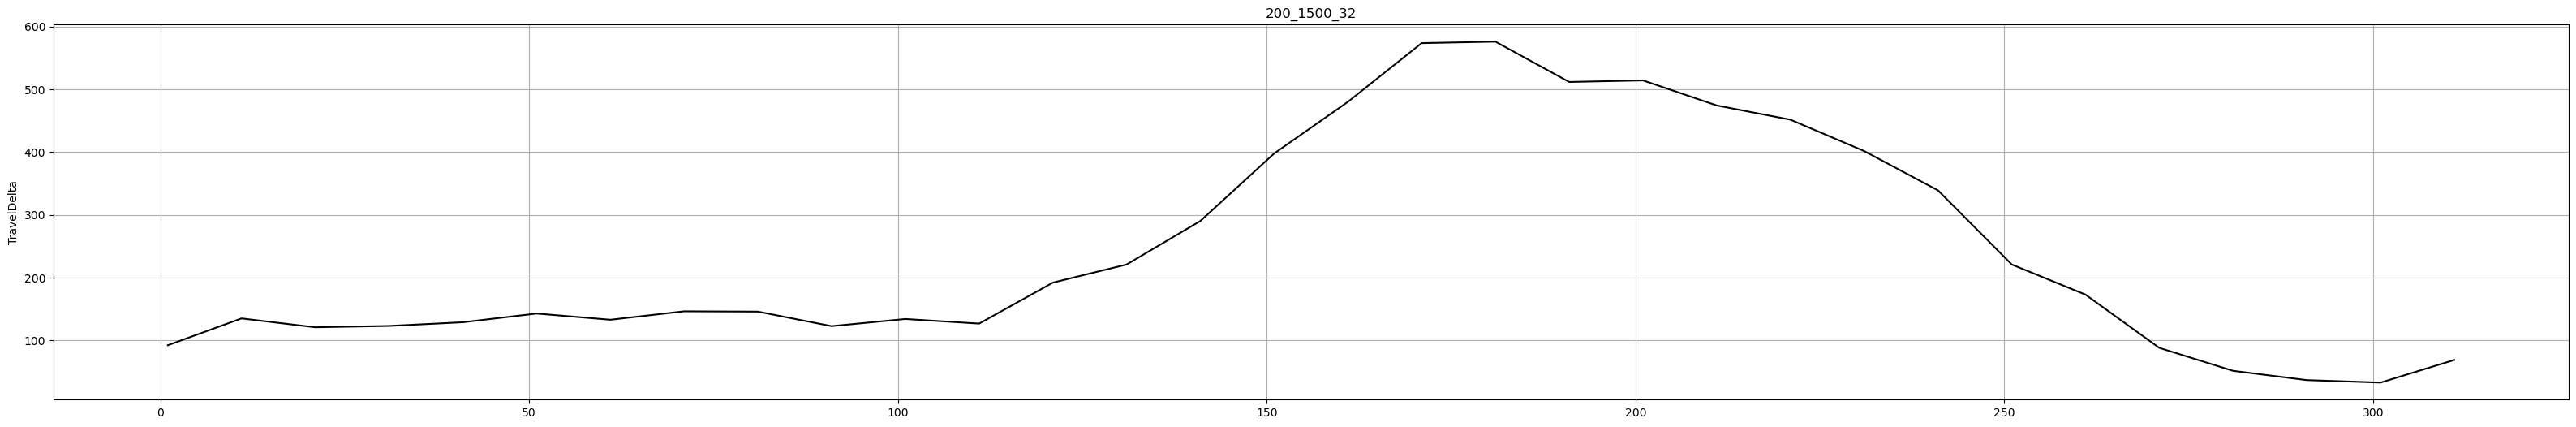

<Figure size 4000x600 with 0 Axes>

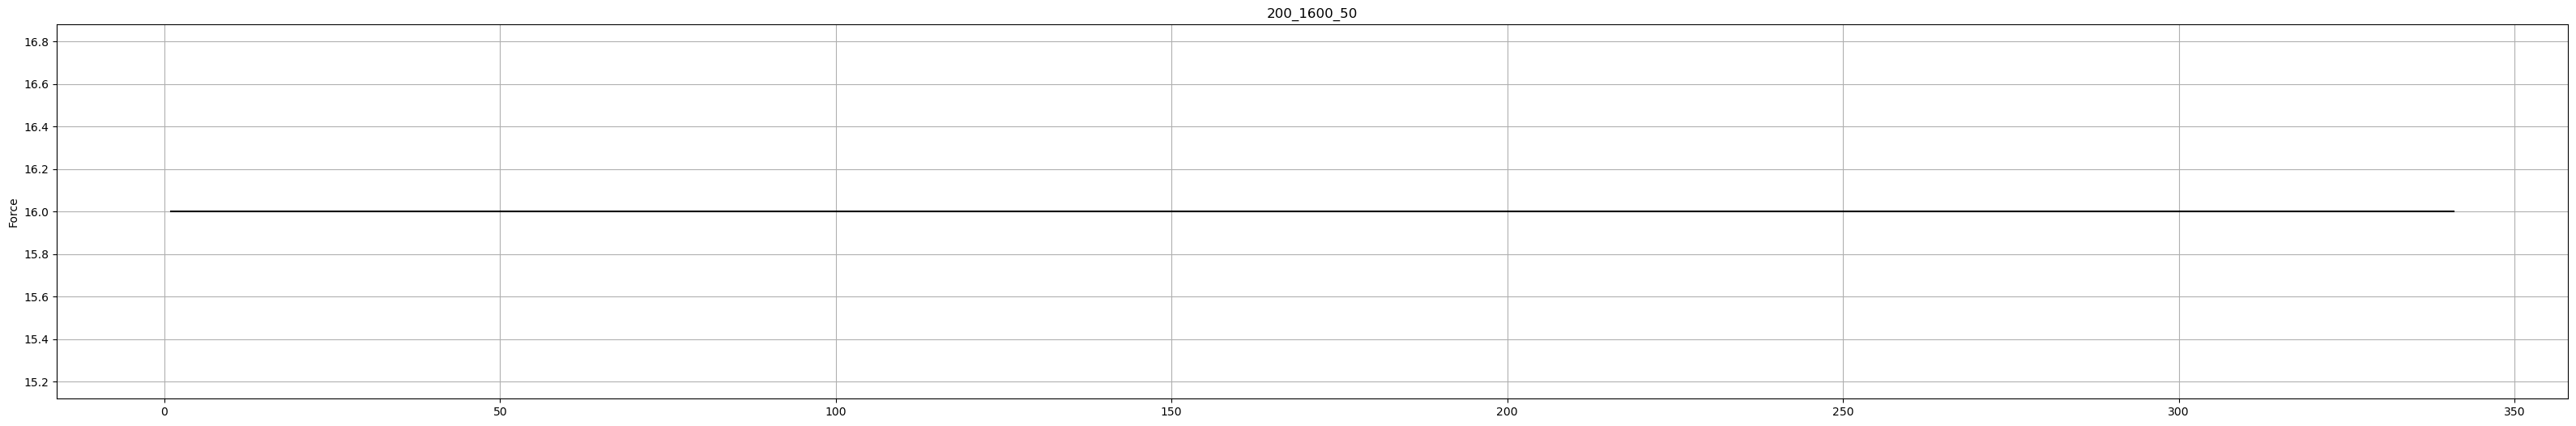

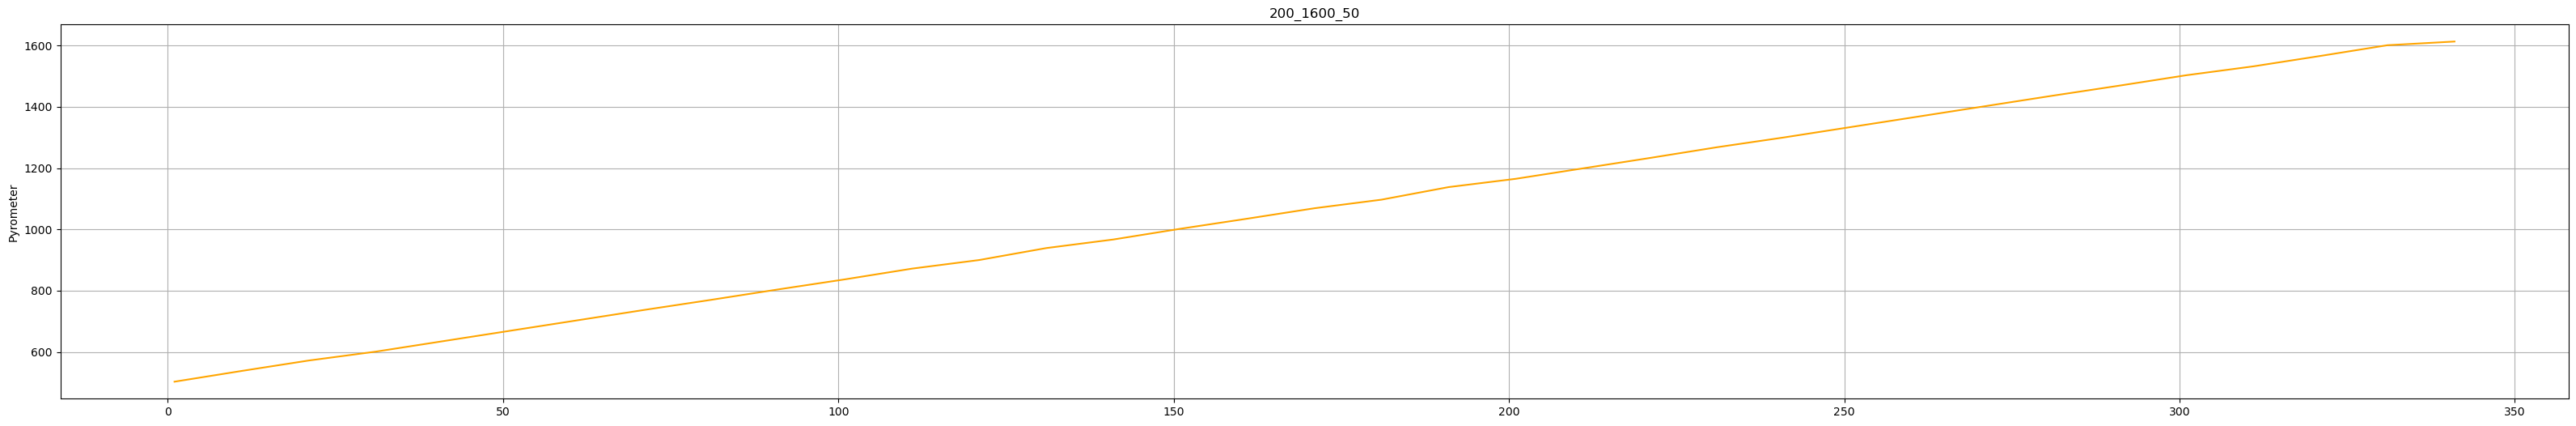

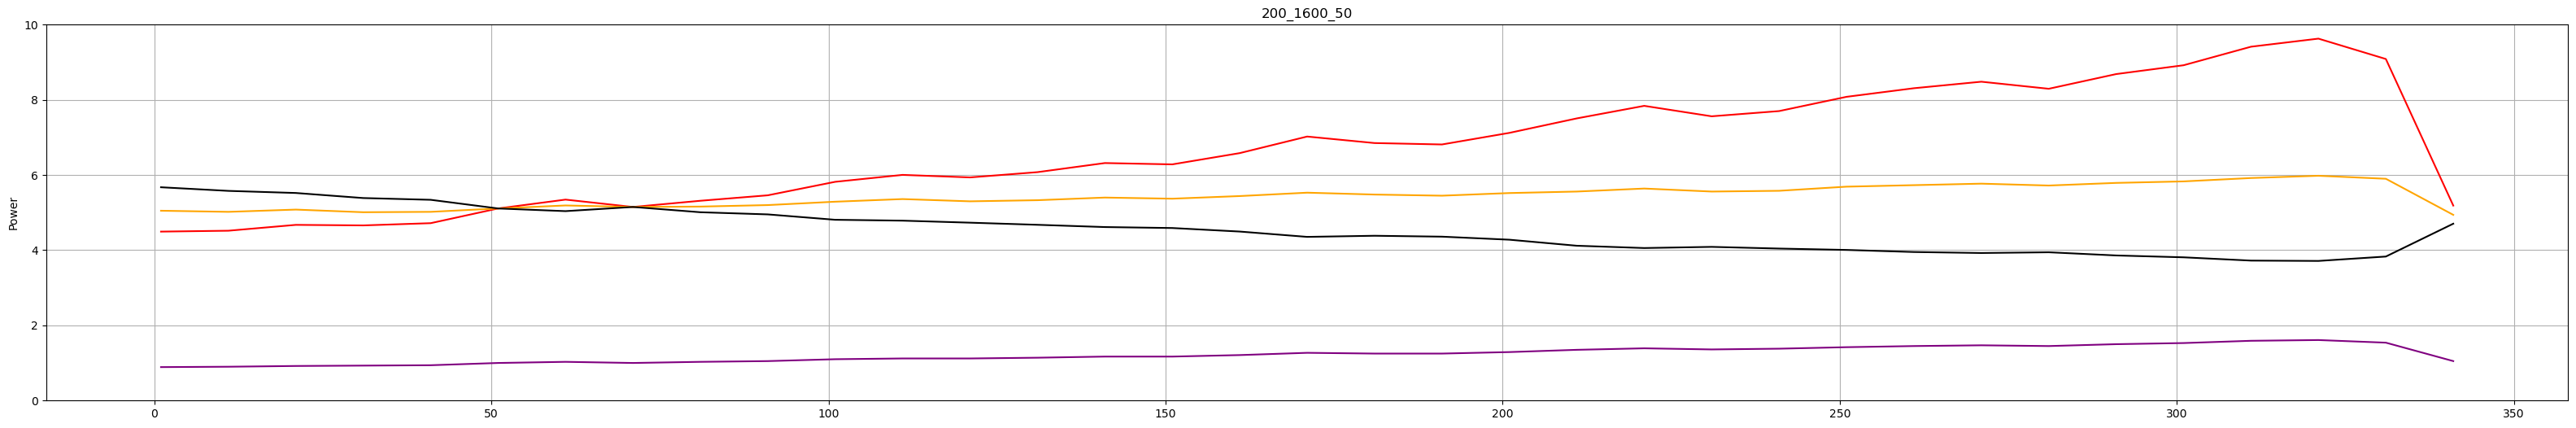

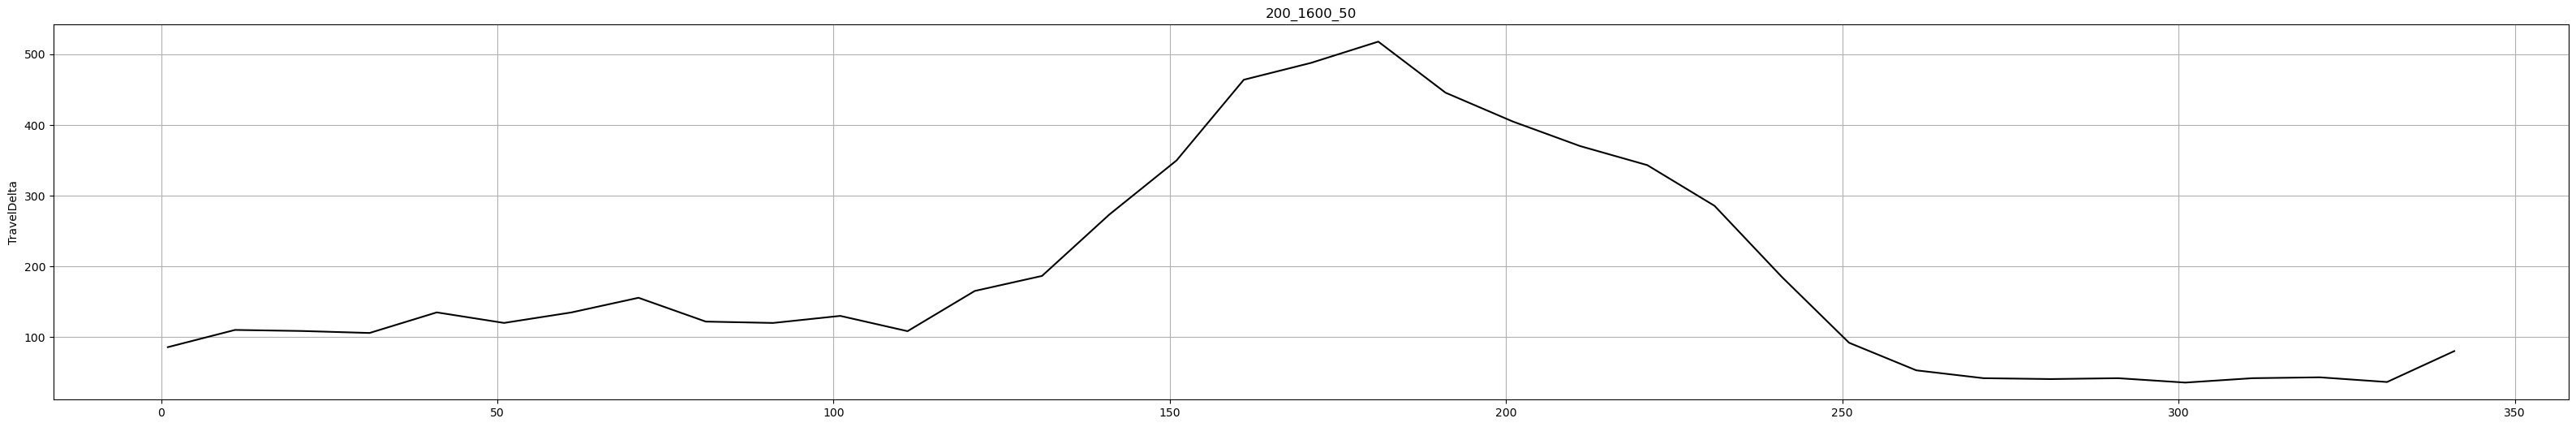

<Figure size 4000x600 with 0 Axes>

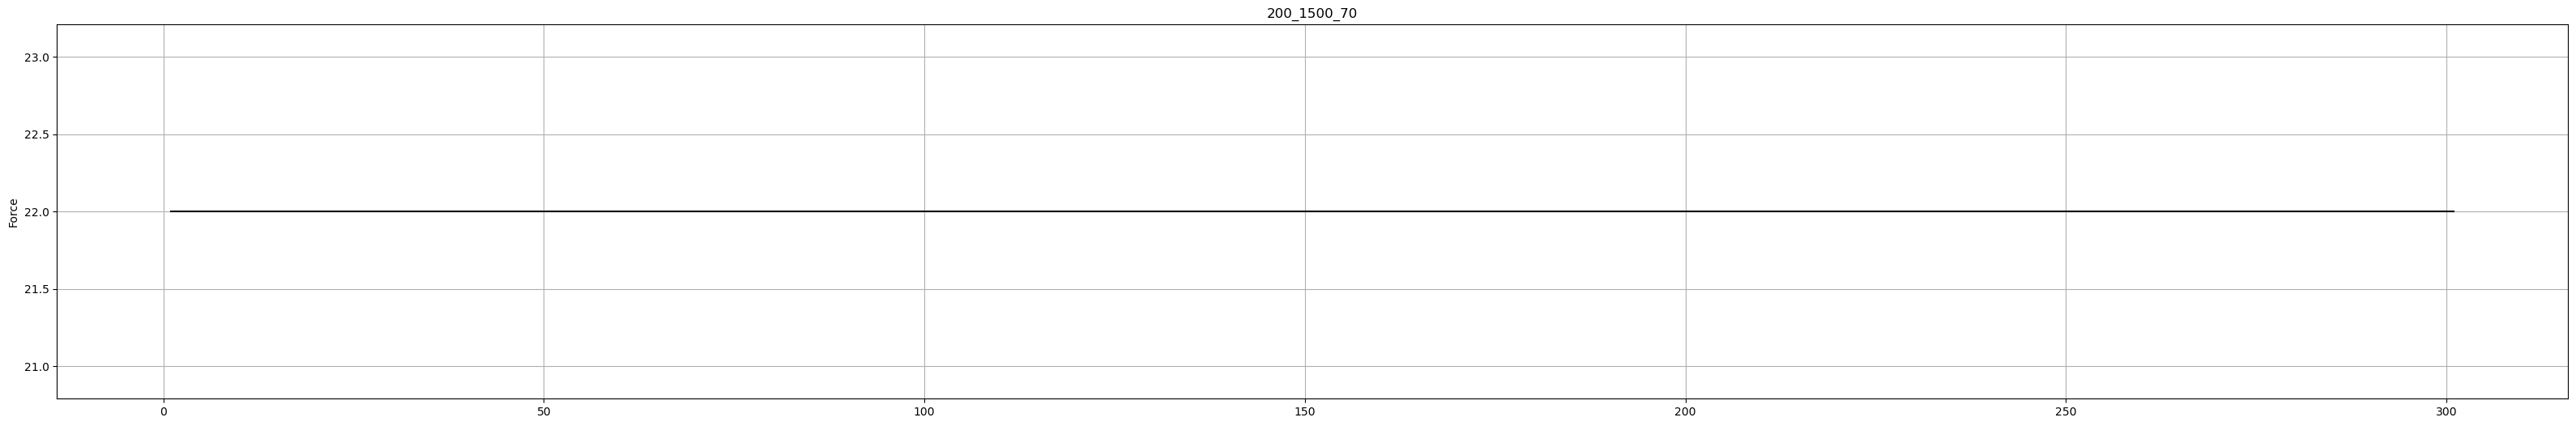

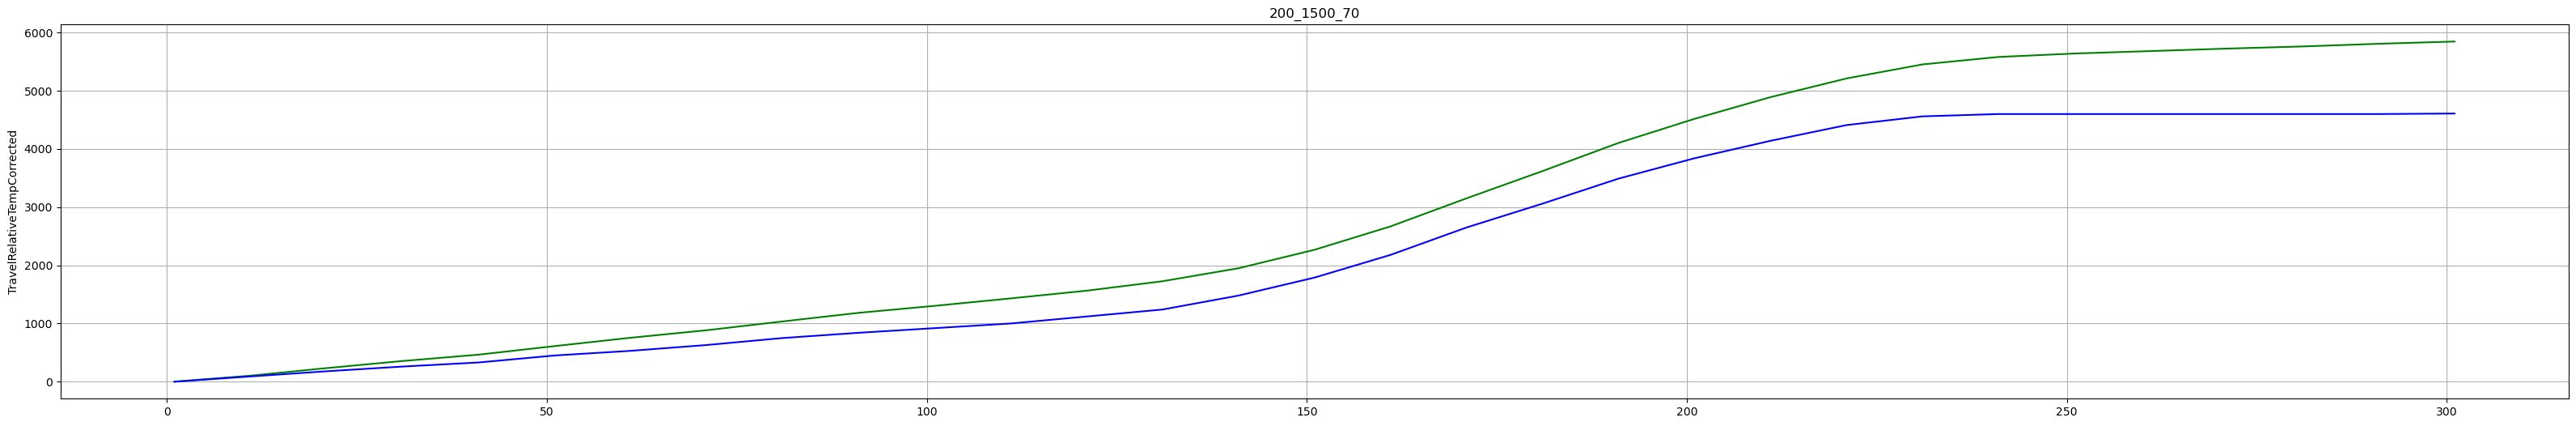

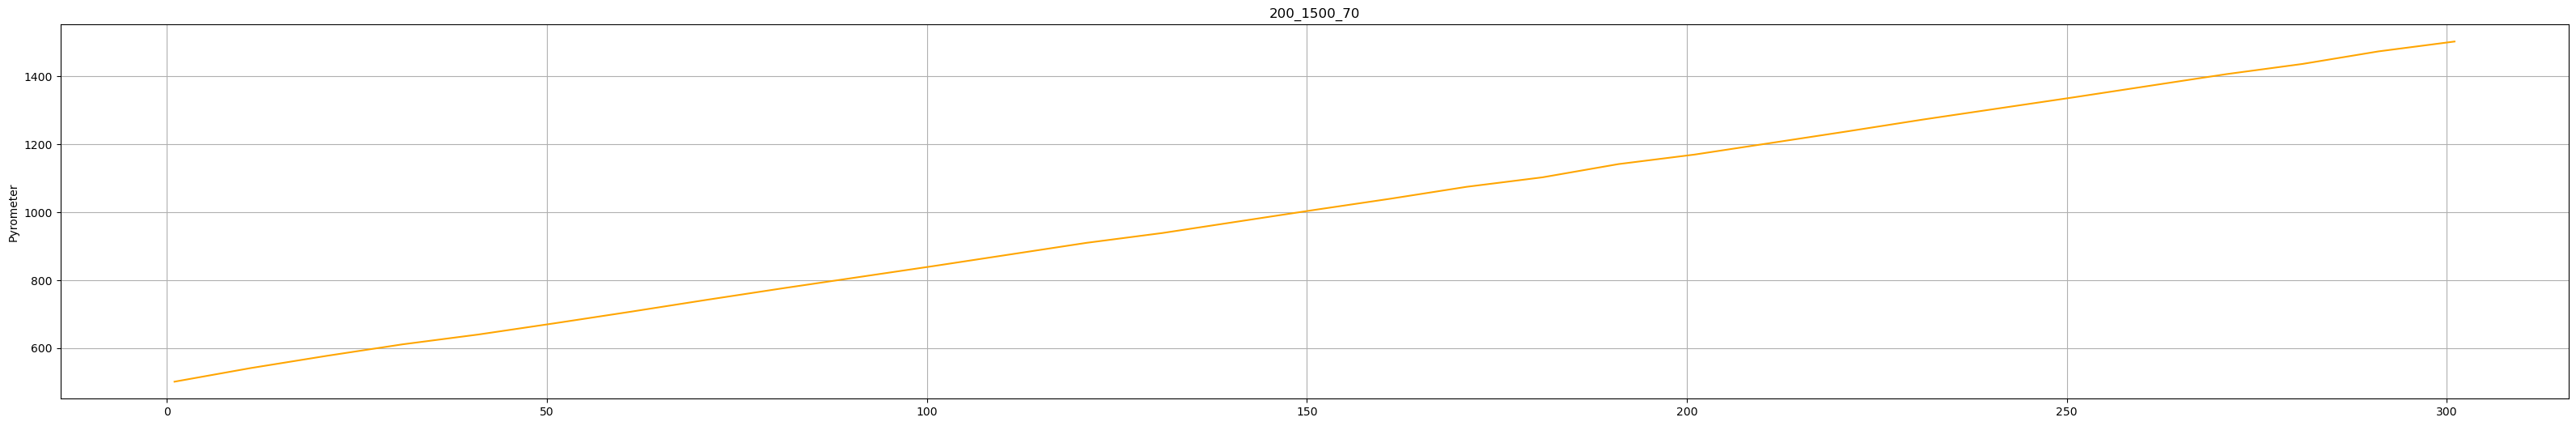

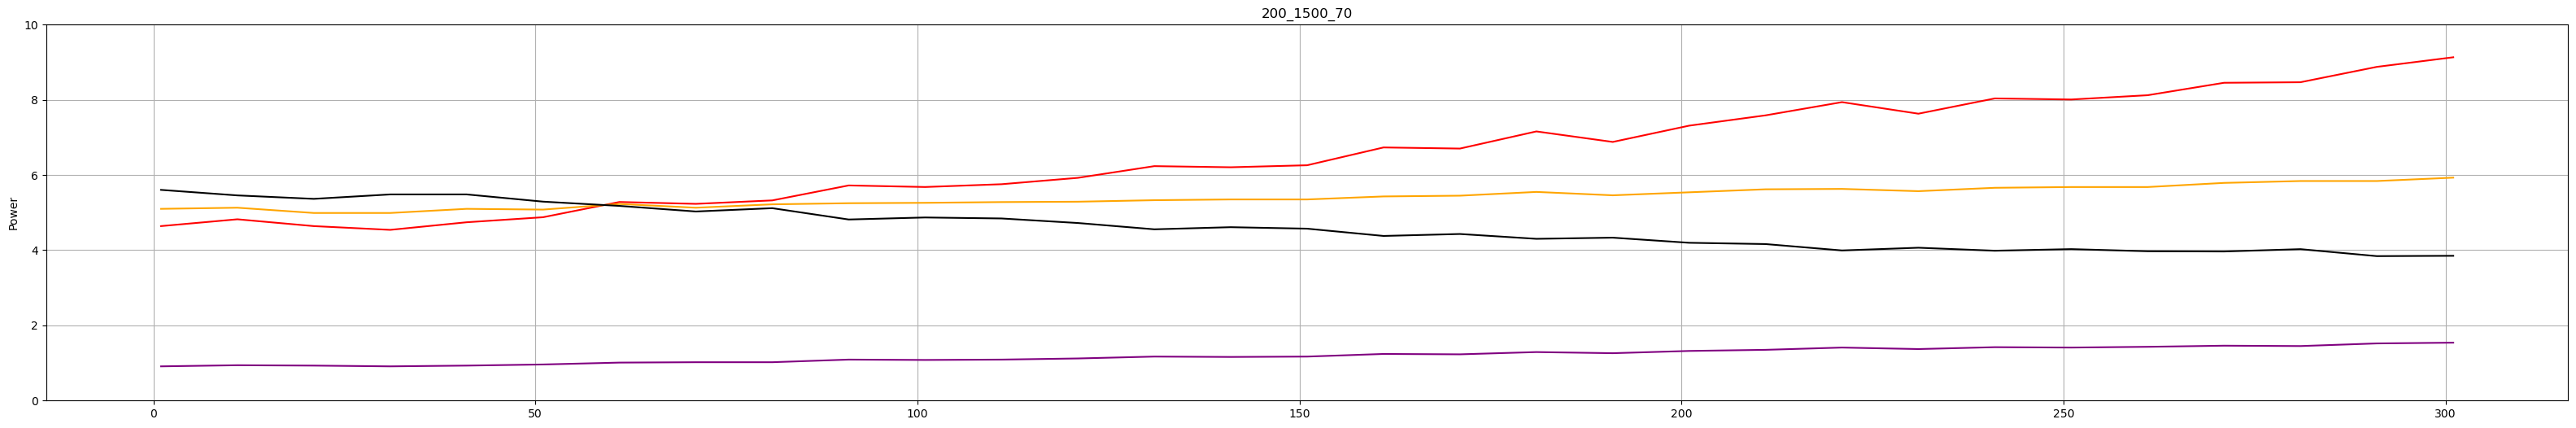

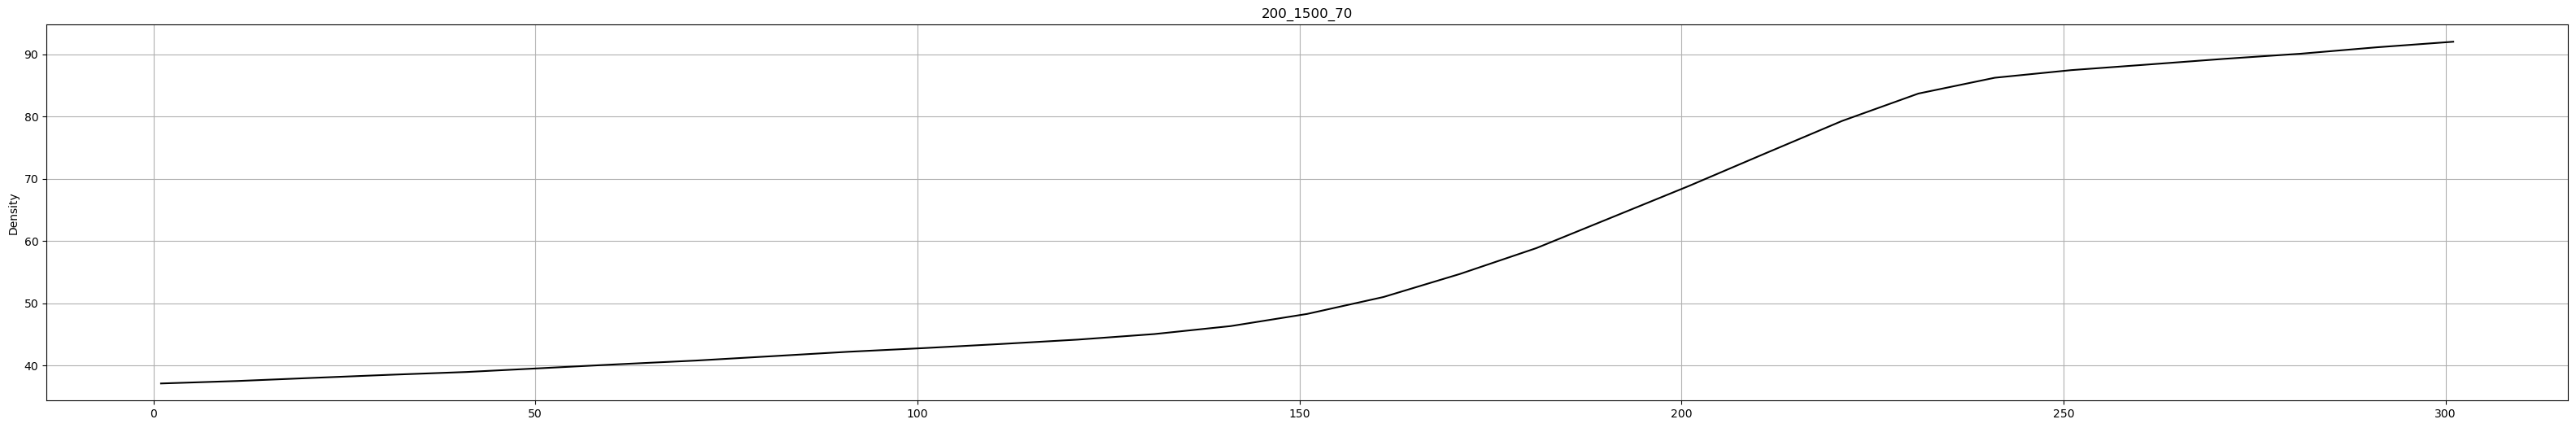

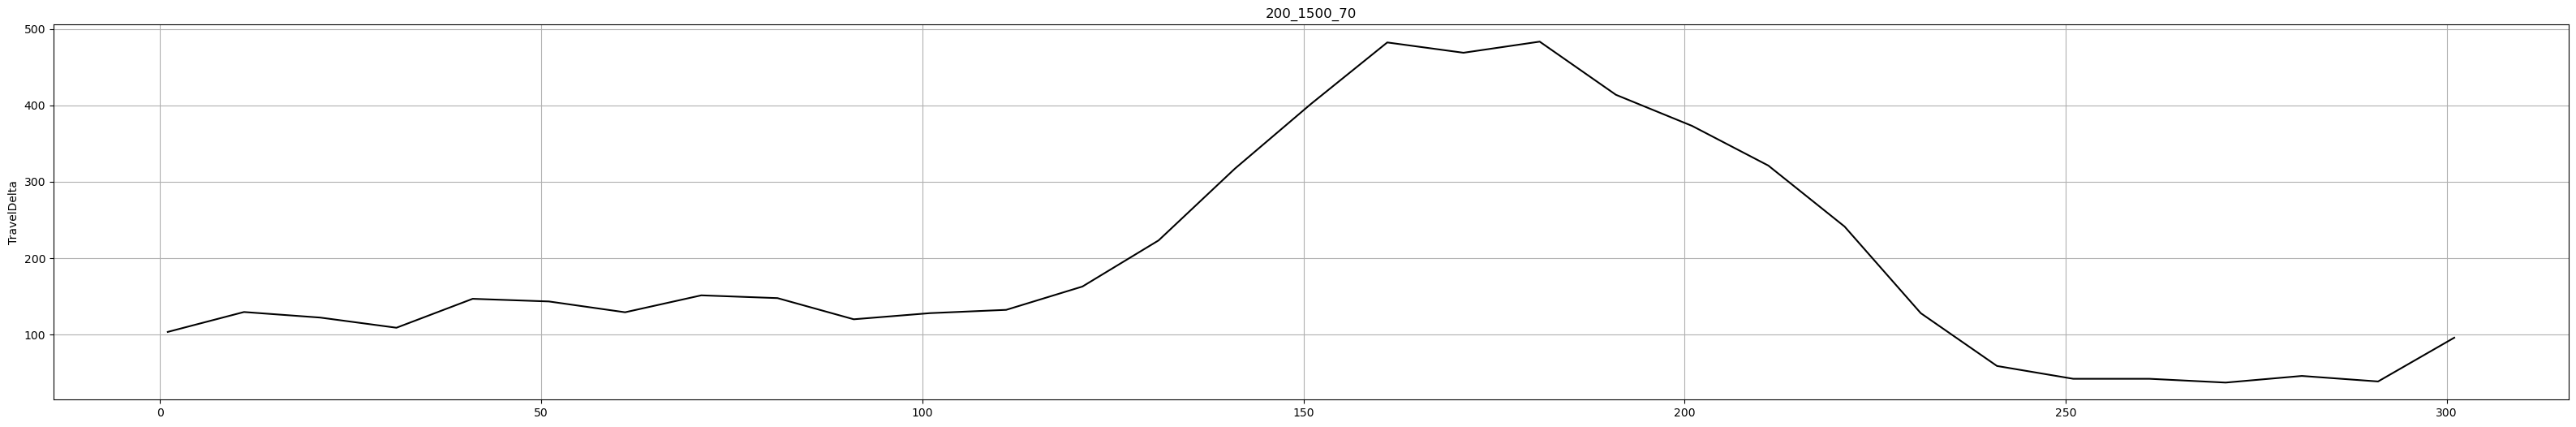

<Figure size 4000x600 with 0 Axes>

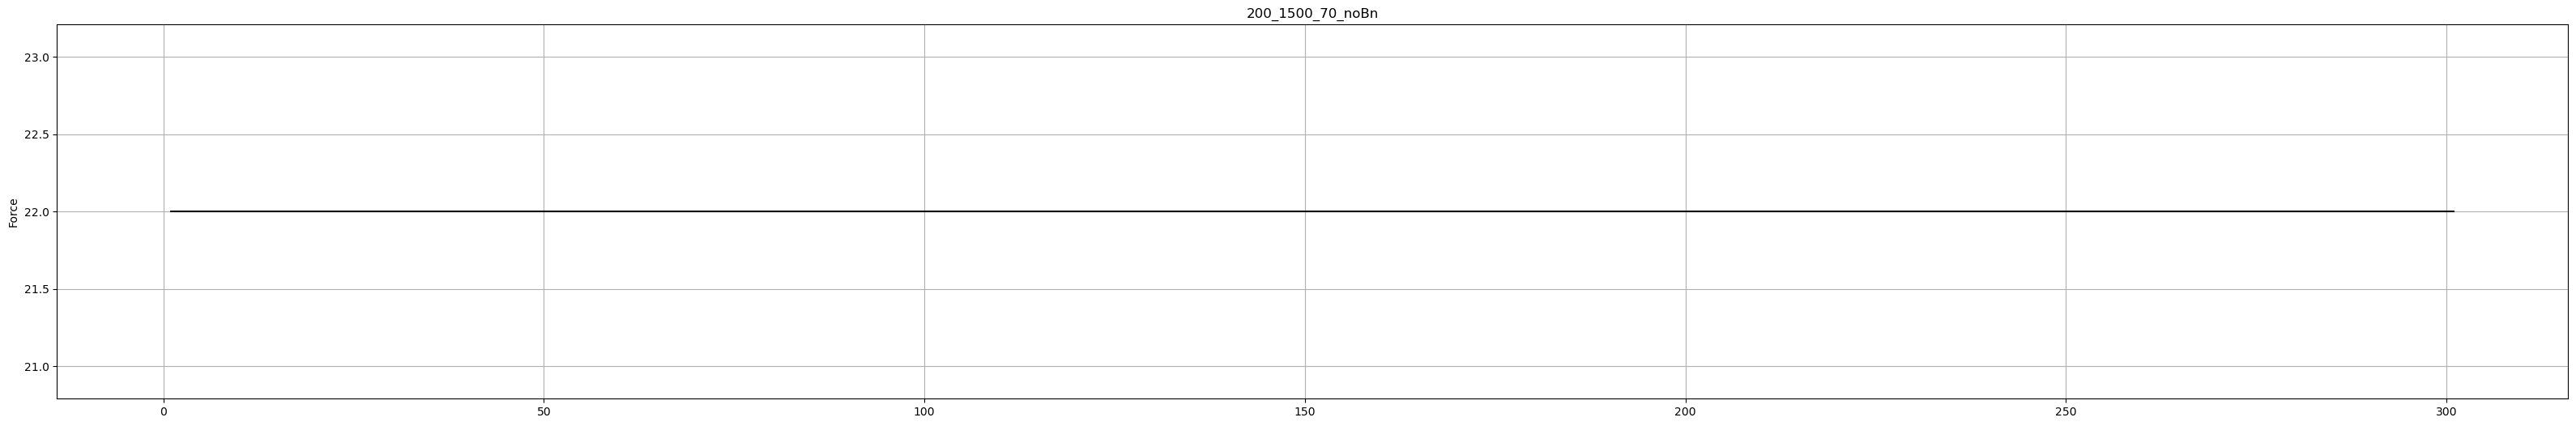

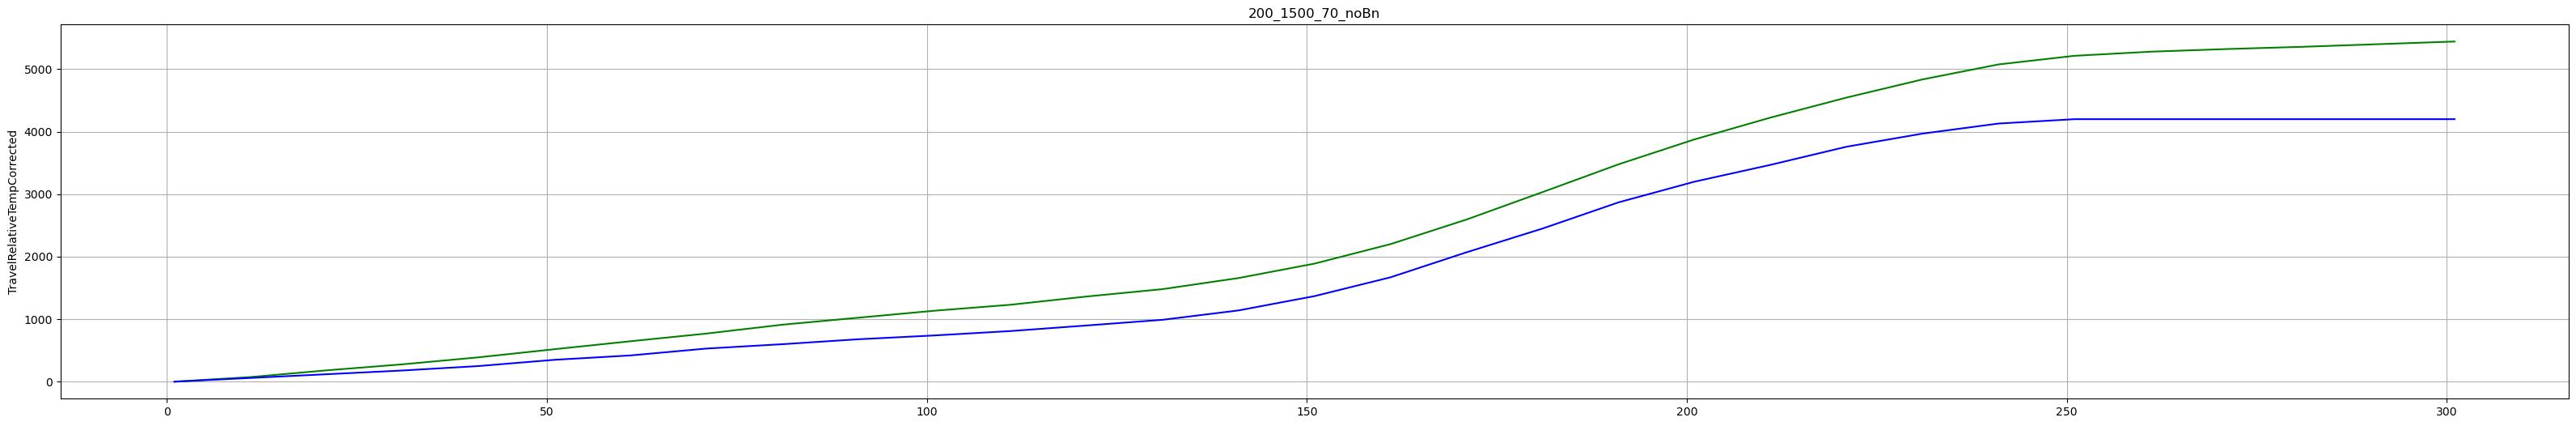

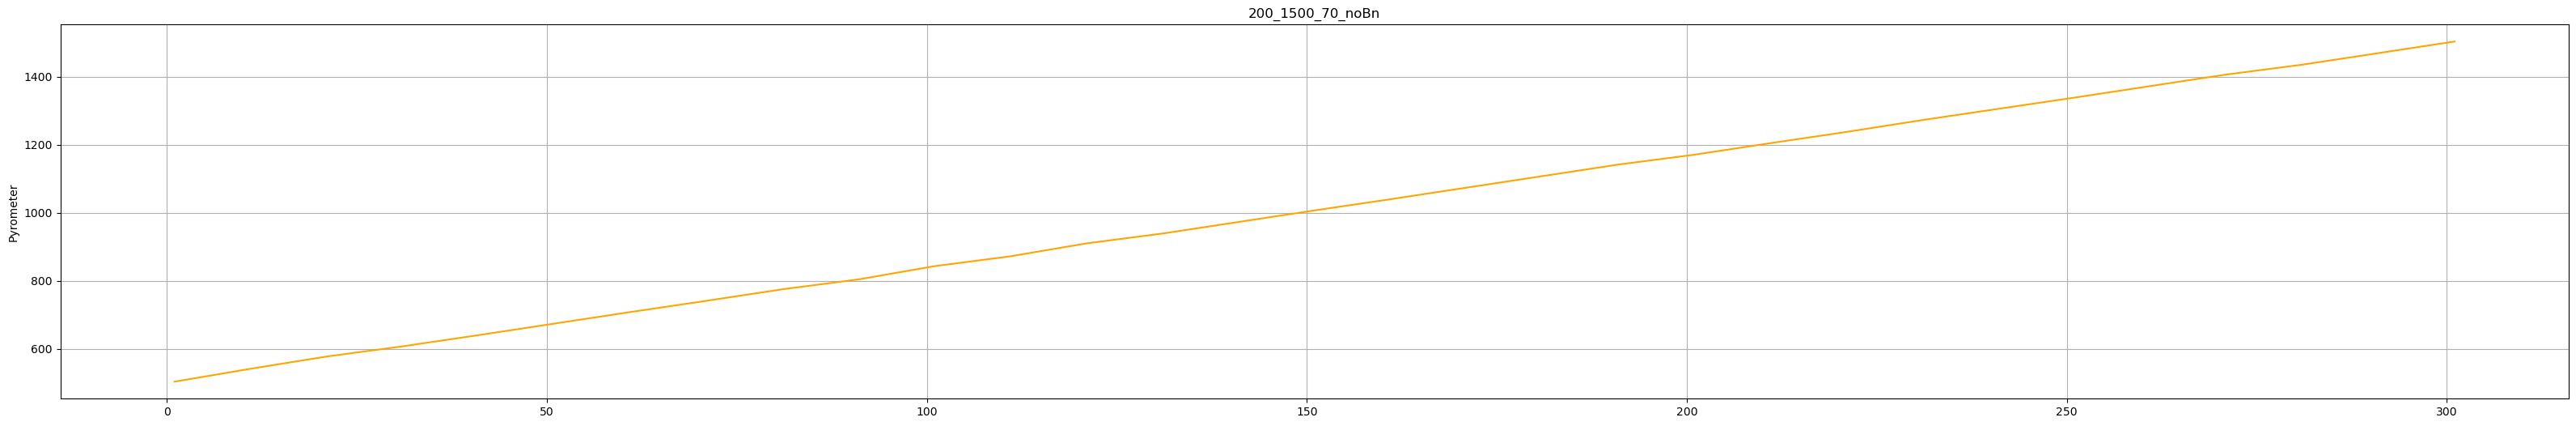

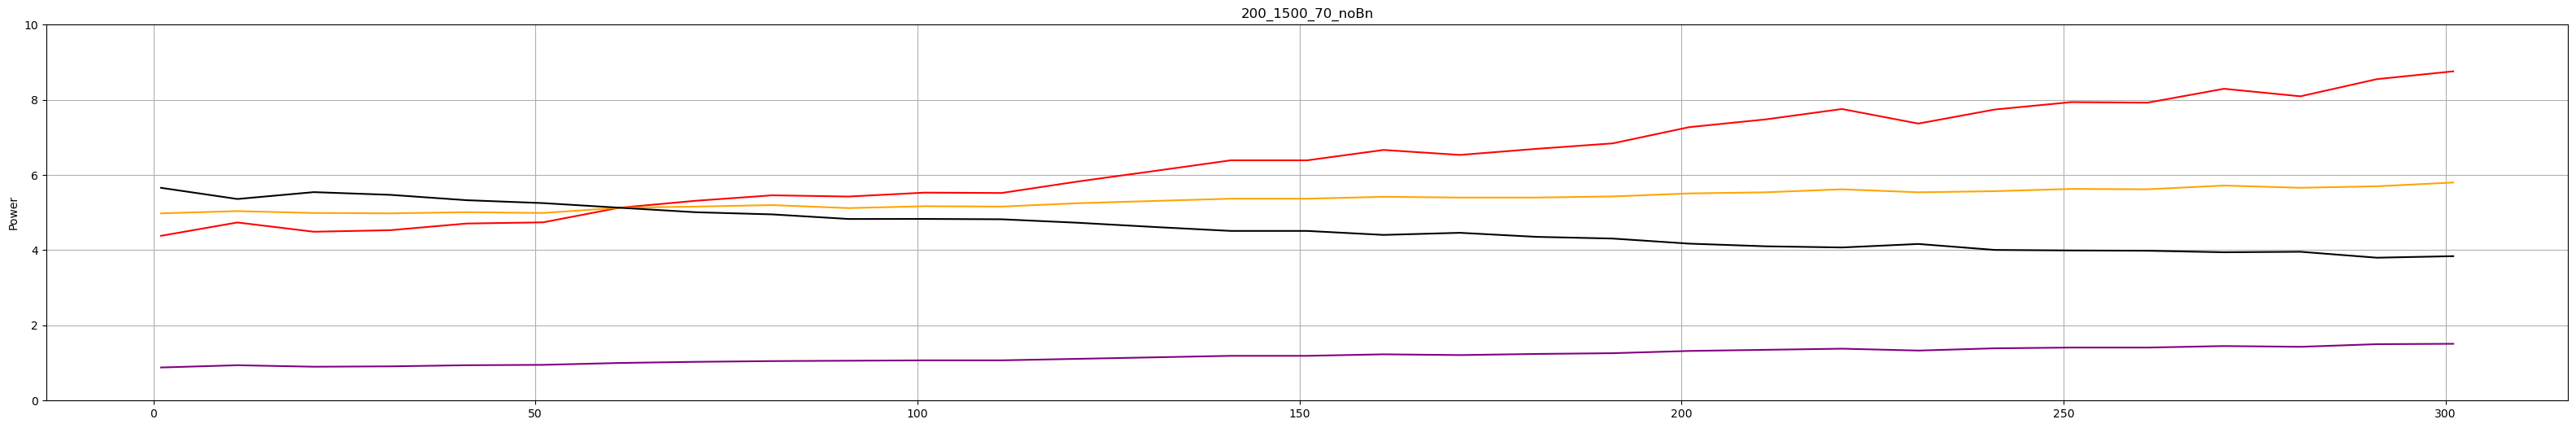

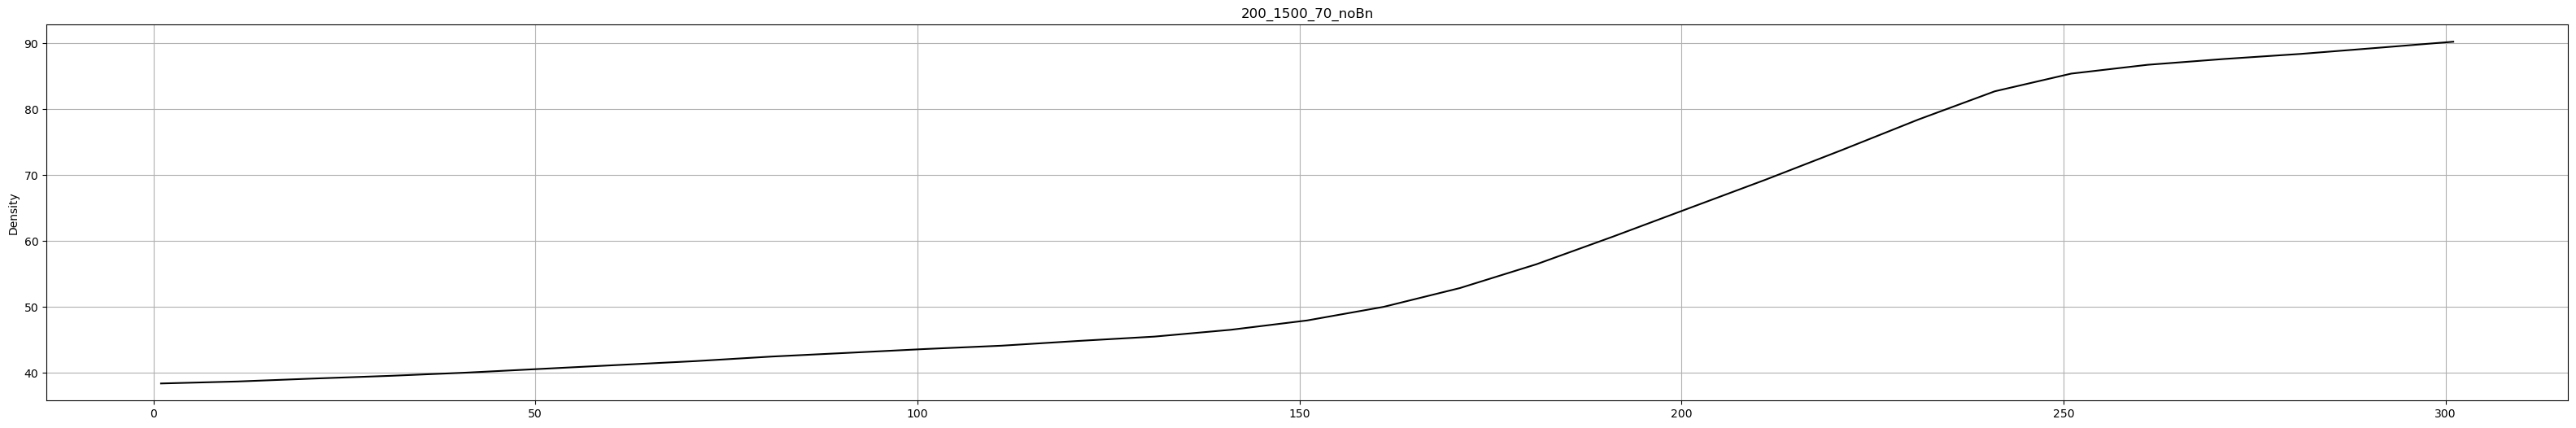

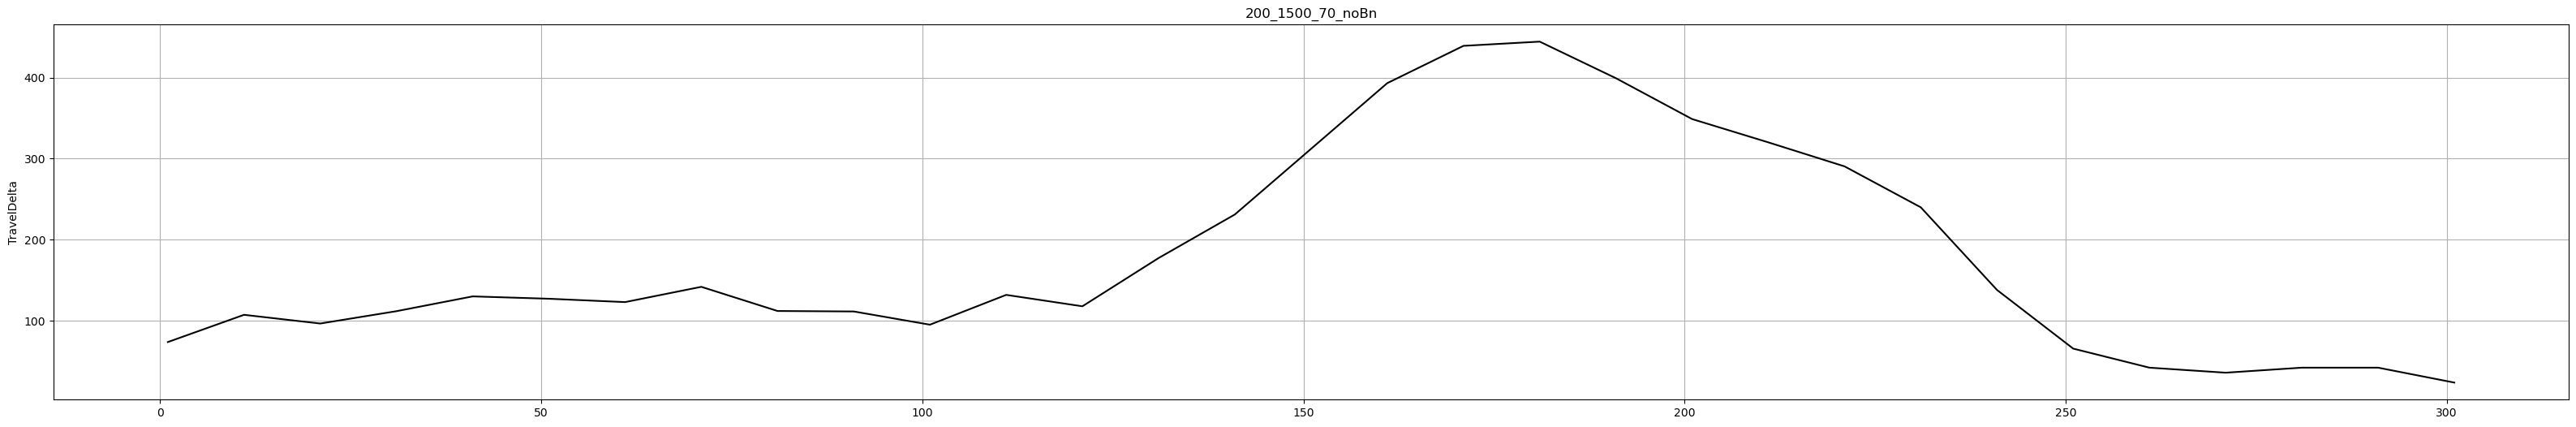

In [9]:
for key in data.keys():
    plot_data_Seconds(data[key], key)


<Figure size 2000x600 with 0 Axes>

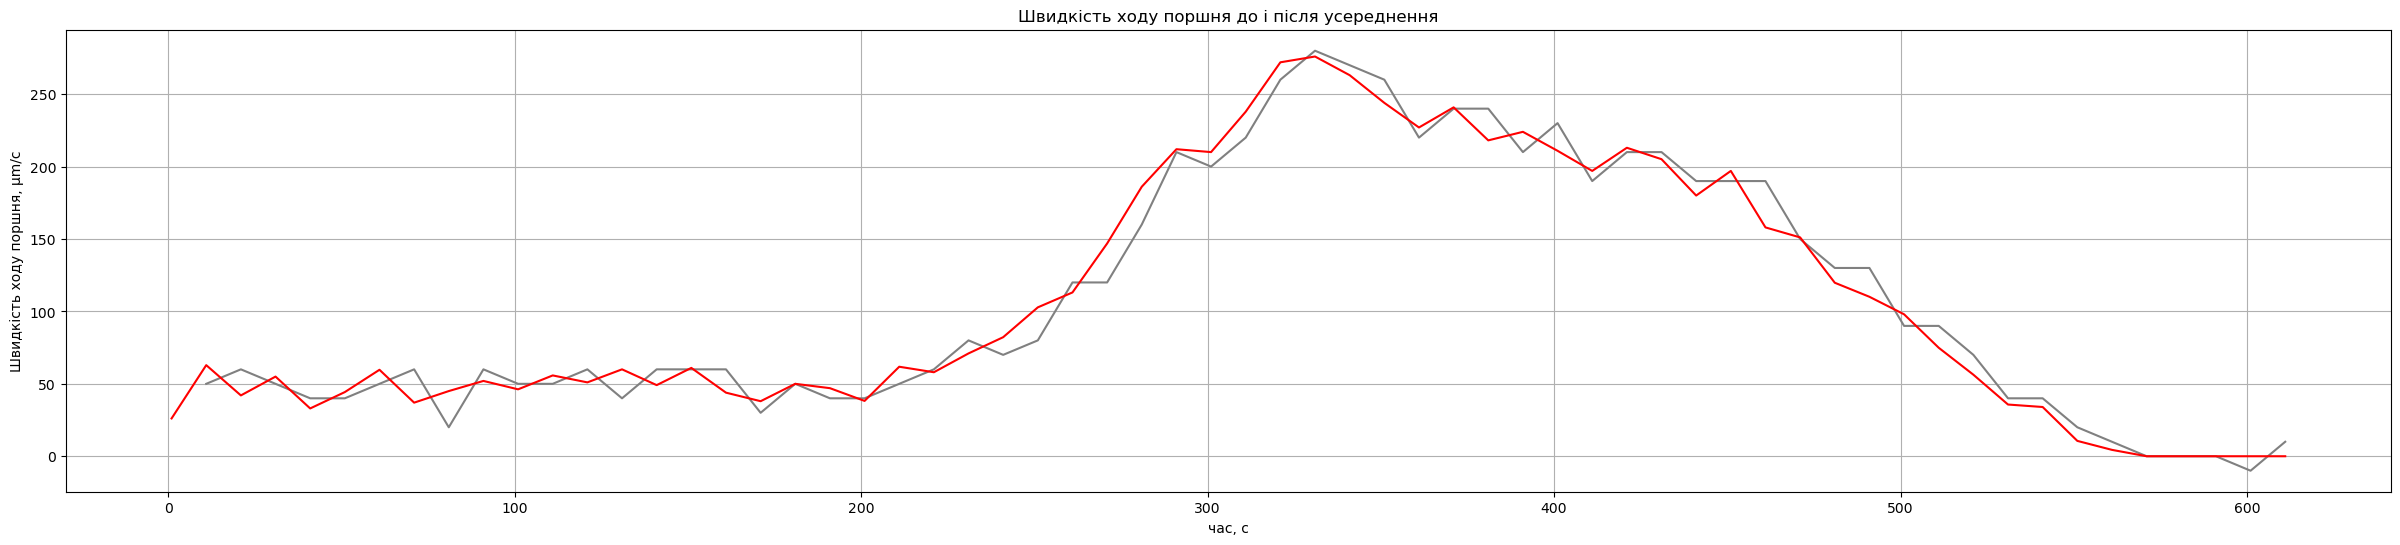

In [10]:
plt.figure(figsize=(20, 6))
fig, ax1 = plt.subplots( figsize=(30, 6))
#sc = ax1.plot(data900['seconds'], data900['TravelDelta'], color='red')  
#sc = ax1.plot(data1000['seconds'], data1000['TravelDelta'], color='green') 
sc = ax1.plot(data['100_1500_32']['seconds'], data['100_1500_32']['TravelDeltaOriginal']*1000, color='gray') 
sc = ax1.plot(data['100_1500_32']['seconds'], data['100_1500_32']['TravelDelta2'], color='red') 
ax1.set_ylabel('Швидкість ходу поршня, μm/с')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('Швидкість ходу поршня до і після усереднення')
ax1.set_xlabel('час, с')
ax1.grid(True)
plt.show()


In [11]:
def plot_data_TravelDelta(data, title):
    setToPlot = data.copy()

    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    sc = ax1.plot(setToPlot['Pyrometer'], setToPlot['TravelDelta'], color='red')  
    ax1.set_ylabel('TravelDelta')
    ax1.set_title(title)
    ax1.set_xlabel('Pyrometer')
    ax1.grid(True)
    plt.show()

<Figure size 4000x600 with 0 Axes>

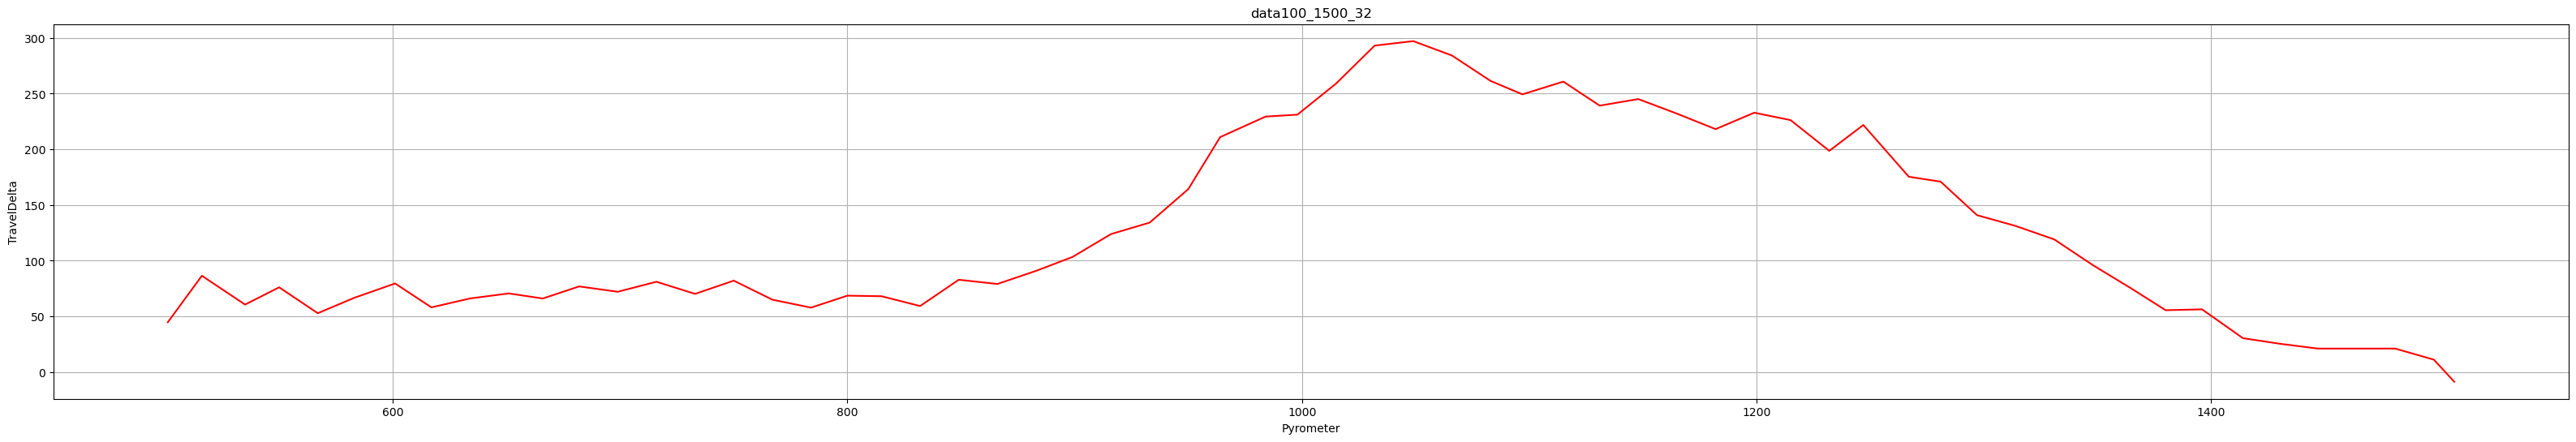

In [12]:
plot_data_TravelDelta(data['100_1500_32'], 'data100_1500_32')


In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Concatenate all experiments into a single dataset
D = pd.concat([data[key] for key in data.keys()], axis=0)

# Select features and target
X = D[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted','Force','Density']].copy()
y = D['TravelRelativeTempCorrectedShifted'].copy()

# Drop rows with missing target or features
mask = y.notna() & X.notnull().all(axis=1)
X = X[mask]
y = y[mask]

# Split into train / test sets (hold out 20% for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# Define candidate kernels with sensible bounds (scaling will help hyperparameters)
kernels = [
   C(1.0, (1e-6, 1e6)) * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)),
   C(1.0, (1e-6, 1e6)) * Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.5),
   C(1.0, (1e-6, 1e6)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-5,1e5), alpha=0.1),
   C(1.0, (1e-6, 1e6)) * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-5,1e5), periodicity=3.0, periodicity_bounds=(1e-3,1e3)),
   C(1.0, (1e-6, 1e6)) * DotProduct(sigma_0=1.0)
]

# Helper wrapper to provide predict(..., return_std=True) using fitted scalers + GPR
class WrappedGPR:
    def __init__(self, x_scaler, gpr, y_scaler):
        self.x_scaler = x_scaler
        self.gpr = gpr
        self.y_scaler = y_scaler
    def predict(self, X, return_std=False):
        import numpy as _np
        X_arr = X.values if hasattr(X, 'values') else _np.asarray(X)
        Xs = self.x_scaler.transform(X_arr)
        if return_std:
            y_pred_s, y_std_s = self.gpr.predict(Xs, return_std=True)
            y_pred = self.y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
            y_std = y_std_s * self.y_scaler.scale_[0]
            return y_pred, y_std
        else:
            y_pred_s = self.gpr.predict(Xs)
            y_pred = self.y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
            return y_pred

# Try each kernel inside a small pipeline that scales X and the target, evaluate on held-out test set
best_mse = float('inf')
best_kernel = None
best_wrapped = None
results = []
# Keep optimizer restarts moderate for better tuning without huge runtime
for k in kernels:
    try:
        # Base GPR that will be trained on scaled inputs
        gpr_base = GaussianProcessRegressor(kernel=k, n_restarts_optimizer=10, alpha=1e-3, random_state=42)
        reg_pipeline = Pipeline([('scaler', StandardScaler()), ('gpr', gpr_base)])
        # Transform target (scale) so optimizer sees normalized y
        model = TransformedTargetRegressor(regressor=reg_pipeline, transformer=StandardScaler())
        model.fit(X_train, y_train)
        # Get predictions on raw X_test (model handles transforms)
        y_pred_k = model.predict(X_test)
        mse_k = mean_squared_error(y_test, y_pred_k)
        results.append((k, mse_k))
        print(f'Kernel: {k} -> test MSE: {mse_k:.6f}')
        if mse_k < best_mse:
            best_mse = mse_k
            best_kernel = k
            # extract fitted components to build wrapper that supports return_std
            fitted_x_scaler = model.regressor_.named_steps['scaler']
            fitted_gpr = model.regressor_.named_steps['gpr']
            fitted_y_scaler = model.transformer_
            best_wrapped = WrappedGPR(fitted_x_scaler, fitted_gpr, fitted_y_scaler)
    except Exception as e:
        print(f'Kernel training failed for {k}: {e}')

if best_wrapped is None:
    raise RuntimeError('All kernel fits failed — check data or reduce kernel complexity')

# Expose the wrapped model as `gpr` for downstream code (supports return_std)
gpr = best_wrapped
print(f'Best kernel selected: {best_kernel} with MSE {best_mse:.6f}')

# Predictions and evaluation (for downstream plotting) — use wrapper to get mean
y_pred = gpr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (best model on test set): {mse:.6f}')

# Reset indices so plotting code downstream works as expected
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred)


Kernel: 1**2 * RBF(length_scale=1) -> test MSE: 1309.642096
Kernel: 1**2 * Matern(length_scale=1, nu=1.5) -> test MSE: 634.860565
Kernel: 1**2 * Matern(length_scale=1, nu=1.5) -> test MSE: 634.860565


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 12 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel: 1**2 * RationalQuadratic(alpha=0.1, length_scale=1) -> test MSE: 1310.007490


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__periodicity is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel: 1**2 * ExpSineSquared(length_scale=1, periodicity=3) -> test MSE: 1308.997298
Kernel: 1**2 * DotProduct(sigma_0=1) -> test MSE: 4410.157241
Best kernel selected: 1**2 * Matern(length_scale=1, nu=1.5) with MSE 634.860565
Mean Squared Error (best model on test set): 634.860565
Kernel: 1**2 * DotProduct(sigma_0=1) -> test MSE: 4410.157241
Best kernel selected: 1**2 * Matern(length_scale=1, nu=1.5) with MSE 634.860565
Mean Squared Error (best model on test set): 634.860565


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 1500x600 with 0 Axes>

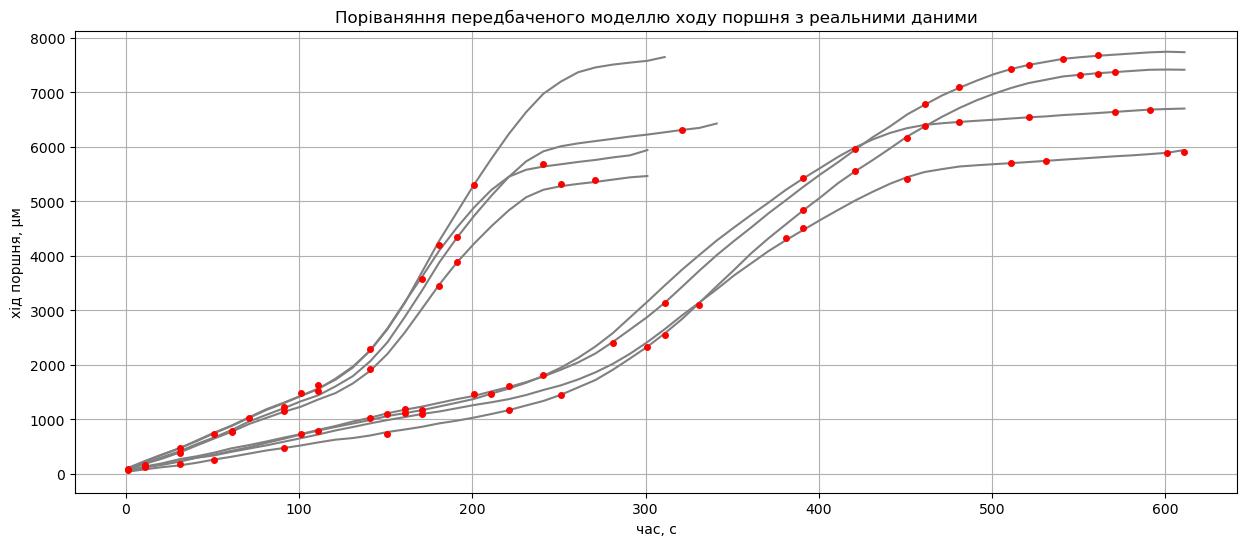

In [14]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
for key in data.keys():
    ax1.plot(data[key]['seconds'], data[key]['TravelRelativeTempCorrectedShifted'], color='grey')
sc = ax1.plot(X_test['seconds'], y_pred, color='red', linestyle='None', marker='o', markersize=4)
ax1.set_title('Поріваняння передбаченого моделлю ходу поршня з реальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()


In [59]:
def calculate_TargetDensificationRateValue(value):
    value = value / 100
    if value < 0.30:
        return 10
    elif 0.30 <= value < 0.50:
        # Лінійне зростання від 0 до 450
        return ((value - 0.30) / (0.50 - 0.30) * 450)+10
    elif 0.50 <= value < 0.70:
        # постійне ущільнення
        return 450
    elif 0.70 <= value < 0.85:
        return 200
    elif 0.85 <= value < 0.97:
        # Лінійне зменшення від 200 до 0
        return (0.97 - value) / (0.97 - 0.85) * 200
    else:
        return 0

def calculate_TargetDensificationRate(column):
    result = []
    for value in column:
        result.append(calculate_TargetDensificationRateValue(value))
    return pd.Series(result, index=column.index)

def find_closest_index(column, target_value):
    squared_diff = (column - target_value) ** 2
    return squared_diff.idxmin()

#calulate_TargetDensificationRate(0.45)


In [60]:
# plot target densification rate vs density for values from 30 to 100
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
for density in range(30, 101):
    target_rate = calculate_TargetDensificationRateValue(density)
    ax1.plot(density, target_rate, color='red', marker='o')
plt.show()

<Figure size 1500x600 with 0 Axes>

In [62]:
# Virtual Experiment: Optimize Sintering Process
# This code simulates a sintering process by iteratively predicting the optimal temperature
# to achieve target densification rates at each time step

# ============================================================================
# Initial Setup
# ============================================================================

# Start from first data point of the reference experiment
virtual_experiment_key = '200_1500_70'
virtual_experiment_start_density = data[virtual_experiment_key]['Density'].iloc[0]
print (f'Starting density: {virtual_experiment_start_density}%')
virtual_experiment_weight = experiments[virtual_experiment_key]['weight']
initial_state = data[virtual_experiment_key].head(1)
prediction_features = initial_state[['seconds', 'TravelRelativeTempCorrected', 'Pyrometer', 
                                      'PyrometerShifted', 'Force', 'Density']]
prediction_features = prediction_features.reset_index(drop=True)

# Initialize simulation parameters
current_time = prediction_features['seconds'].iloc[0]
num_temperature_options = 60  # Number of temperature scenarios to evaluate at each step
time_step = 10  # Seconds between predictions
max_simulation_time = 1000  # Maximum simulation duration
target_density = 96  # Target relative density percentage

# Store the predicted sintering regime
predicted_regime = prediction_features.copy()

# Create multiple prediction scenarios (will be populated in loop)
prediction_scenarios = pd.concat([predicted_regime] * num_temperature_options, ignore_index=True)

# ============================================================================
# Simulation Loop
# ============================================================================

is_heating = True
current_density = 32  # Starting density percentage

# Initialize prediction scenarios with different temperature options
current_time += time_step
for i in range(num_temperature_options):
    prediction_scenarios.loc[i, 'seconds'] = current_time
    # Temperature offset from -5 to +54 degrees relative to current temperature
    prediction_scenarios.loc[i, 'PyrometerShifted'] = prediction_scenarios['PyrometerShifted'].iloc[i] + i - 5

# Main simulation loop: continue until time limit or target density reached
while current_time < max_simulation_time and current_density < target_density:
    
    # ========================================================================
    # Step 1: Predict outcomes for all temperature scenarios
    # ========================================================================
    travel_predictions, prediction_std = gpr.predict(prediction_scenarios, return_std=True)
    
    # ========================================================================
    # Step 2: Calculate densification rates for each scenario
    # ========================================================================
    current_travel = prediction_scenarios['TravelRelativeTempCorrected'].iloc[0]
    densification_rates = (travel_predictions - current_travel) / time_step / 1000
    
    # Update current density based on predicted travel
    current_density = calculate_densityForVirtualExperiment(current_travel, virtual_experiment_weight, virtual_experiment_start_density)
    
    # ========================================================================
    # Step 3: Select best temperature option
    # ========================================================================
    # Calculate target densification rate for current density
    target_rate = calculate_TargetDensificationRateValue(current_density)
    #print(f'Target rate: {target_rate}')
    
    # Find which scenario gives densification rate closest to target
    predicted_rates_series = pd.Series(travel_predictions - current_travel)
    #print(predicted_rates_series)
    best_scenario_index = find_closest_index(predicted_rates_series, target_rate)
    
    # ========================================================================
    # Step 4: Update prediction scenarios for next time step
    # ========================================================================
    current_time += time_step
    
    for i in range(num_temperature_options):
        prediction_scenarios.loc[i, 'seconds'] = current_time
        prediction_scenarios.loc[i, 'TravelRelativeTempCorrected'] = travel_predictions[best_scenario_index]
        prediction_scenarios.loc[i, 'Pyrometer'] = prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index]
        
        # Generate temperature scenarios: heating up or cooling down
        if is_heating:
            # Temperature offset from -20 to +39 degrees
            prediction_scenarios.loc[i, 'PyrometerShifted'] = \
                prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index] + i - 20
        else:
            # Cool down by 30 degrees
            prediction_scenarios.loc[i, 'PyrometerShifted'] = \
                prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index] - 30
    
    # ========================================================================
    # Step 5: Record the selected scenario in the regime
    # ========================================================================
    best_prediction = prediction_scenarios.iloc[best_scenario_index]
    best_prediction_df = pd.DataFrame([best_prediction])
    
    predicted_regime = pd.concat([predicted_regime, best_prediction_df], ignore_index=True)
    predicted_regime.at[predicted_regime.index[-1], 'STD'] = prediction_std[best_scenario_index]
    
    # Progress tracking
    print(f'Time: {current_time}s')
    print(f'Density: {current_density:.2f}%')

# Display first few rows of the predicted regime
predicted_regime.head(10)

Starting density: 37.11039854577653%
Time: 21s
Density: 37.11%
Time: 31s
Density: 37.49%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Time: 41s
Density: 37.93%
Time: 51s
Density: 38.43%
Time: 61s
Density: 39.00%
Time: 71s
Density: 39.65%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Time: 81s
Density: 40.39%
Time: 91s
Density: 41.26%
Time: 101s
Density: 42.31%
Time: 111s
Density: 43.61%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Time: 121s
Density: 45.28%
Time: 131s
Density: 47.36%
Time: 141s
Density: 49.95%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Time: 151s
Density: 53.31%
Time: 161s
Density: 57.55%
Time: 171s
Density: 62.71%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Time: 181s
Density: 69.17%
Time: 191s
Density: 77.51%
Time: 201s
Density: 88.71%
Time: 211s
Density: 104.54%


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


seconds  TravelRelativeTempCorrected  Pyrometer  PyrometerShifted  Force  \
0      1.0                     0.000000      501.0             541.0   22.0   
1     21.0                    99.774472      595.0             634.0   22.0   
2     31.0                   212.452335      634.0             673.0   22.0   
3     41.0                   337.399328      673.0             712.0   22.0   
4     51.0                   475.311209      712.0             751.0   22.0   
5     61.0                   627.412133      751.0             790.0   22.0   
6     71.0                   796.170687      790.0             829.0   22.0   
7     81.0                   986.003234      829.0             868.0   22.0   
8     91.0                  1203.974278      868.0             907.0   22.0   
9    101.0                  1460.118812      907.0             946.0   22.0   

     Density        STD  
0  37.110399        NaN  
1  37.110399  63.117483  
2  37.110399  27.243071  
3  37.110399  29.458555  
4  37.110399  32.188364  
5  37.110399  35.123225  
6  37.110399  38.295459  
7  37.110399  41.906813  
8  37.110399  46.208953  
9  37.110399  51.536822

(-20.0, 45.0)

<Figure size 1500x600 with 0 Axes>

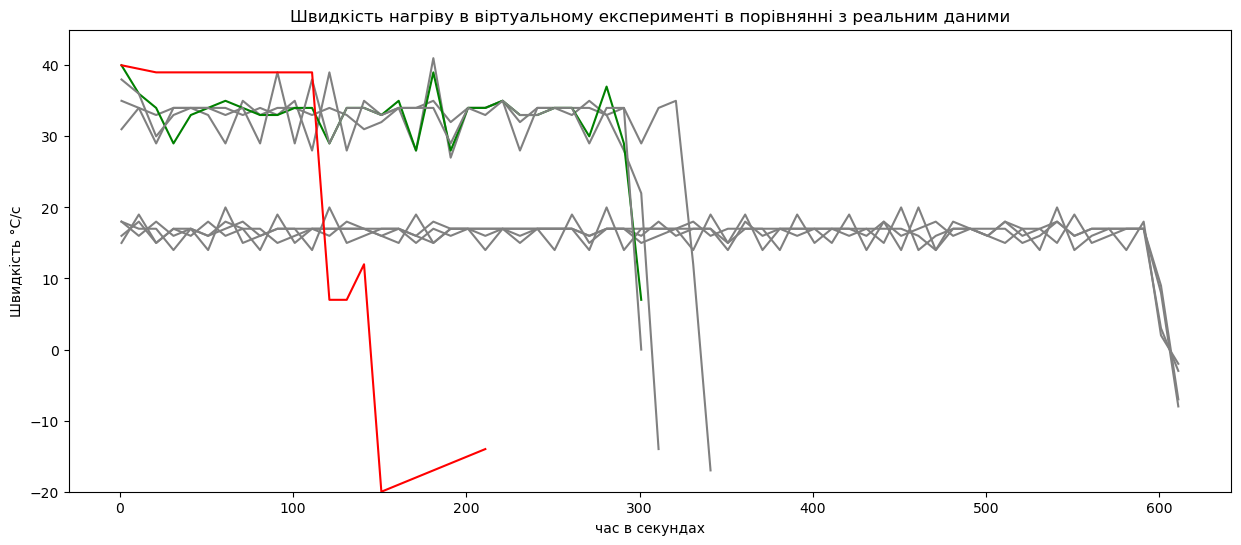

In [63]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
#heating rate

for key in data.keys():
    if key == virtual_experiment_key:
        ax1.plot(data[key]['seconds'], data[key]['PyrometerShifted'] - data[key]['Pyrometer'], color='green')
    else:
        ax1.plot(data[key]['seconds'], data[key]['PyrometerShifted'] - data[key]['Pyrometer'], color='gray')
sc = ax1.plot(predicted_regime['seconds'], predicted_regime['PyrometerShifted'] - predicted_regime['Pyrometer'], color='red') 
ax1.set_title('Швидкість нагріву в віртуальному експерименті в порівнянні з реальним даними')
ax1.set_xlabel('час в секундах')
ax1.set_ylabel('Швидкість °C/c')
ax1.set_ylim(-20, 45 )


In [64]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(20, 6))
fig, ax2 = plt.subplots( figsize=(20, 6))
#heating rate

ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['Pyrometer'], color='green') 
ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['PyrometerShifted'] , color='lime') 
ax1.plot(predicted_regime['seconds'], predicted_regime['Pyrometer'], color='red') 
ax1.plot(predicted_regime['seconds'], predicted_regime['PyrometerShifted'] , color='orange') 


ax2.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['TravelDelta'], color='gray')
ax2.plot( predicted_regime['seconds'], predicted_regime['TravelRelativeTempCorrected'] - predicted_regime['TravelRelativeTempCorrected'].shift(1), color='red')
ax2.plot( predicted_regime['seconds'], calculate_TargetDensificationRate(calculate_densityForVirtualExperiment(predicted_regime['TravelRelativeTempCorrected'], virtual_experiment_weight, virtual_experiment_start_density)), color='green')
#ax1.set_title('Швидкість нагріву в віртуальному експерименті в порівнянні з реальним даними')
ax1.set_xlabel('час в секундах')
ax1.set_ylabel('temperature °C')
ax2.set_ylabel('TravelDelta μm/s')
#ax1.set_ylim(-20, 45 )


Text(0, 0.5, 'TravelDelta μm/s')

<Figure size 1500x600 with 0 Axes>

In [65]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#densification rate
sc = ax1.plot( calculate_densityForVirtualExperiment(predicted_regime['TravelRelativeTempCorrected'], virtual_experiment_weight, virtual_experiment_start_density), predicted_regime['TravelRelativeTempCorrected'] - predicted_regime['TravelRelativeTempCorrected'].shift(1), color='red')
sc = ax1.plot( calculate_densityForVirtualExperiment(predicted_regime['TravelRelativeTempCorrected'], virtual_experiment_weight, virtual_experiment_start_density), calculate_TargetDensificationRate(calculate_densityForVirtualExperiment(predicted_regime['TravelRelativeTempCorrected'], virtual_experiment_weight, virtual_experiment_start_density)), color='green')
sc = ax1.plot(data[virtual_experiment_key]['Density'], data[virtual_experiment_key]['TravelDelta'], color='grey')

#sc = ax1.plot(calulate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48), newRegime['STD'], color='blue') 

#ax1.set_title('title')
ax1.set_xlabel('Щільність')
ax1.set_ylabel('Швидкість ущільнення')
ax1.grid(True)
plt.show()


<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

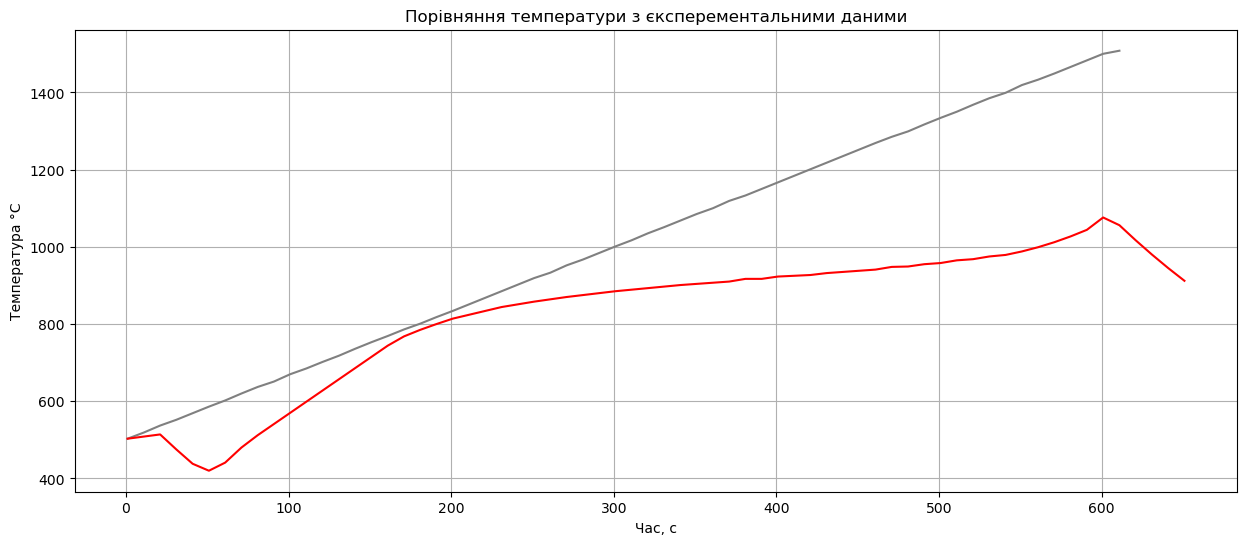

In [42]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#Temperature
sc = ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['Pyrometer'], color='grey')
sc = ax1.plot(predicted_regime['seconds'], predicted_regime['Pyrometer'], color='red')

ax1.set_title('Порівняння температури з єксперементальними даними')
ax1.set_xlabel('Час, с')
ax1.set_ylabel('Температура °C')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

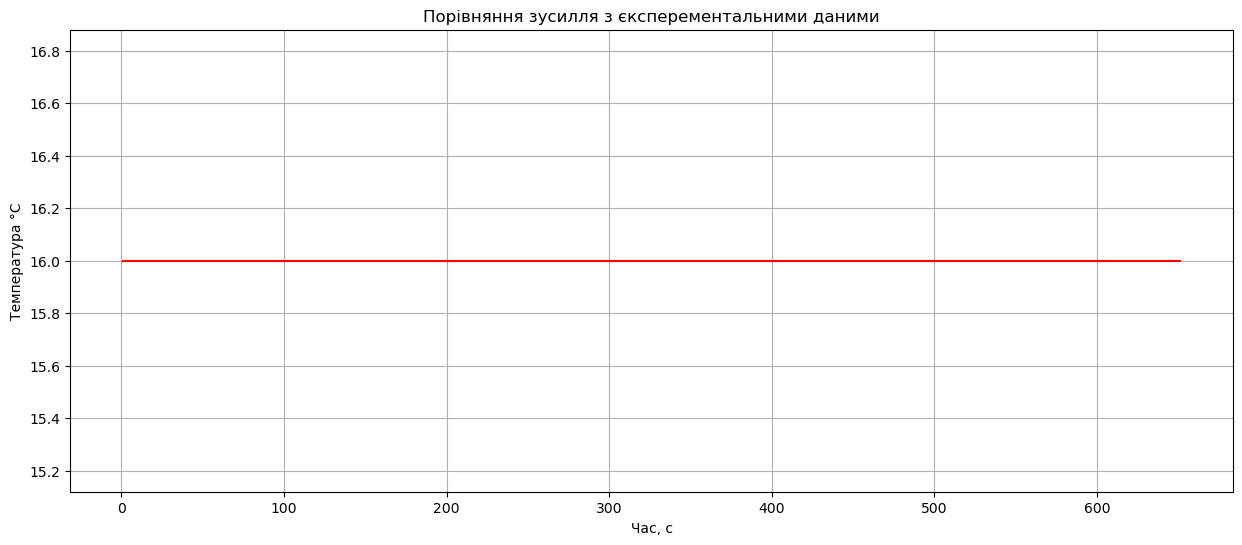

In [43]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#Temperature
sc = ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['Force'], color='grey')
sc = ax1.plot(predicted_regime['seconds'], predicted_regime['Force'], color='red')

ax1.set_title('Порівняння зусилля з єксперементальними даними')
ax1.set_xlabel('Час, с')
ax1.set_ylabel('Температура °C')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

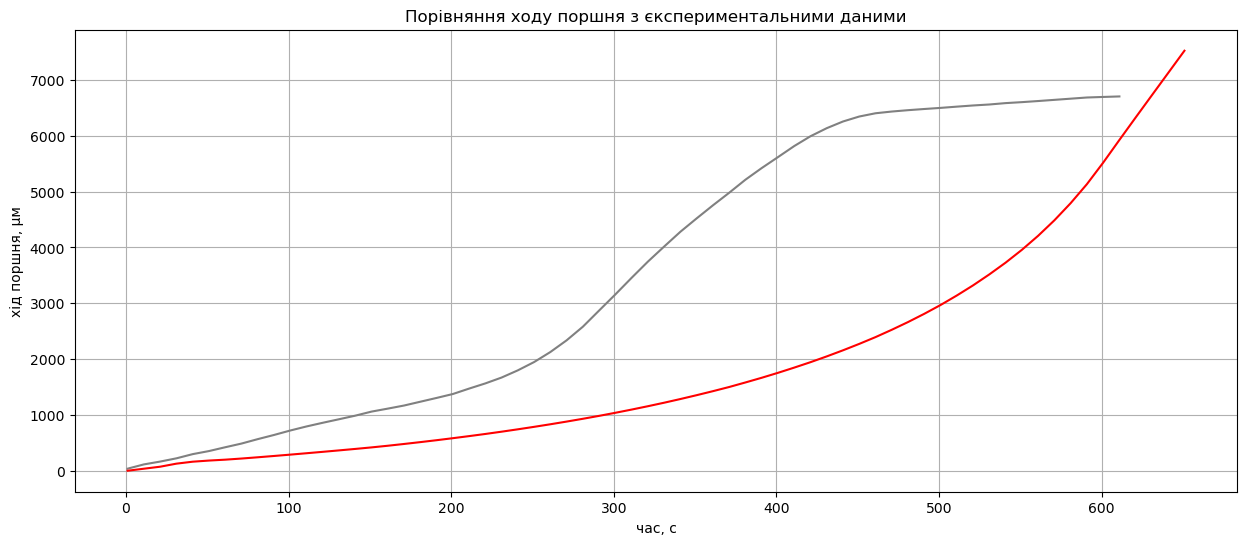

In [44]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

sc = ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(predicted_regime['seconds'], predicted_regime['TravelRelativeTempCorrected'], color='red') 
 
ax1.set_title('Порівняння ходу поршня з єкспериментальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

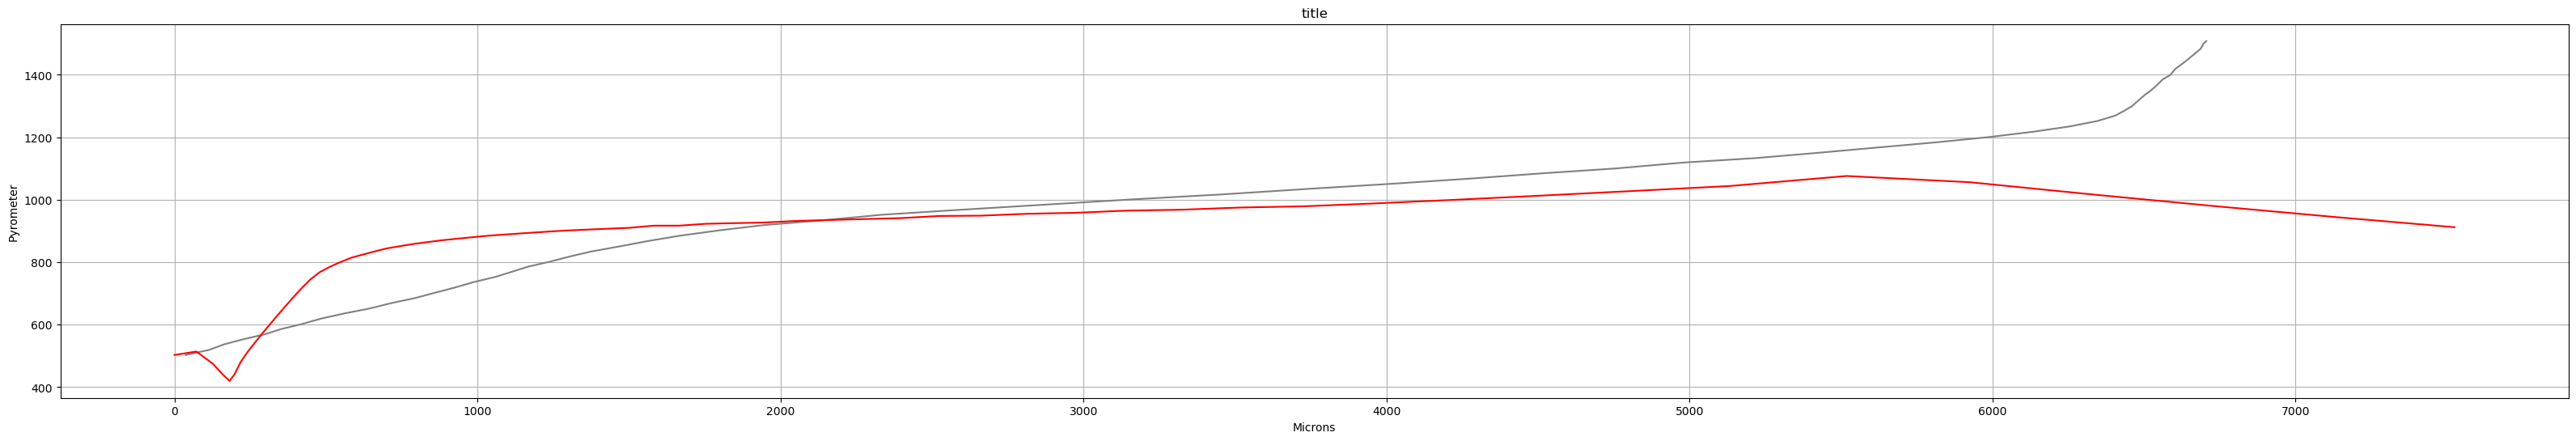

In [45]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data[virtual_experiment_key]['TravelRelativeTempCorrectedShifted'], data[virtual_experiment_key]['Pyrometer'], color='grey') 
sc = ax1.plot(predicted_regime['TravelRelativeTempCorrected'], predicted_regime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('Microns')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

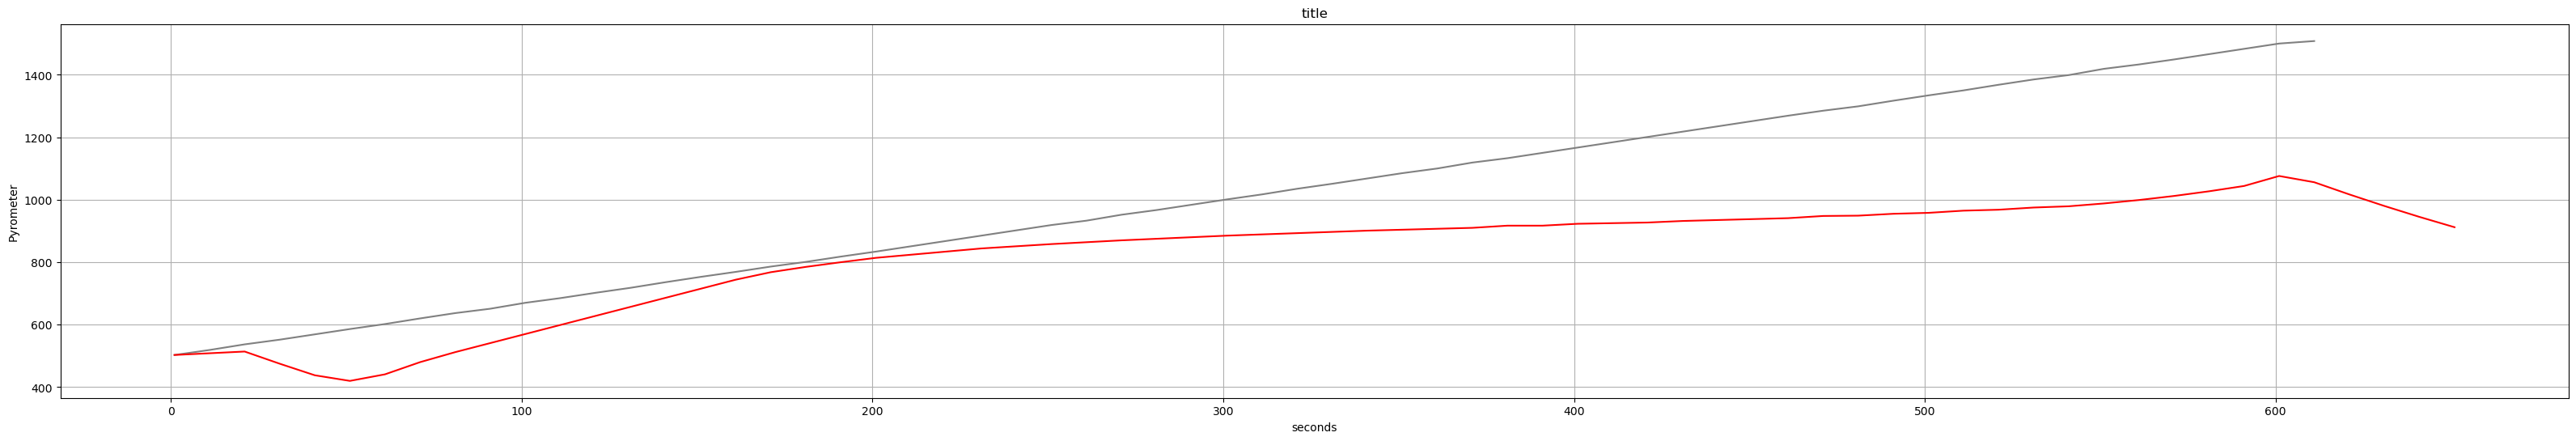

In [46]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data[virtual_experiment_key]['seconds'], data[virtual_experiment_key]['Pyrometer'], color='grey') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['Pyrometer'], color='grey') 
sc = ax1.plot(predicted_regime['seconds'], predicted_regime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('seconds')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()